## Introduction

### Project background
Major SEA Telecom Provider providing telecom services to prepaid and postpaid customer segments combined with variety of product offers and plans.

### Business problem
Company's postpaid business of voice only plans is struggling to maintain its strong foothold in local market because of,
1. High churn rate amongst customers leading to a revenue decline of ~500k USD every month
2. Decline in overall customer base (high churn rate combined with low acquisition rate), leading to a decline in total market share

### Project objective
Reduce monthly customer churn by identifying high risk customers well in advance.

### Hypothesis 
Company CEO believes that existing models can predict churners precisely, but it's too late to take any retention actions, as customers usage have significantly declined by then.

### Analytic objective
1. Build a classification model to predict churners one month in advance
2. Identify key churn drivers

### What is provided?

Data provided for 50k customers who are currently availing voice only postpaid plans from the telecom provider

- Customer profile - Months in service, Unique subscribers, Active subs, Service area, handset, model, Age HH1, Age HH2, Marital status, Occupation, Home ownership, Has Credit card, Owns motorcycle, Credit rating and changes over time, etc.

- Customer Revenue - Monthly revenue, recurring revenue from prior month, Percentage change in revenue
- Customer Usage and Activity- Monthly minutes, percent change in minutes, Overage minutes, Inbound & outbound calls, Peak & off-peak calls, dropped/blocked/unanswered calls, roaming calls, etc.
- Customer Interaction - Customer care calls, Responds to mail offers, Retention calls, Retention offer accepted, referrals made, etc.
- Churn - Churn/ Non-churn flag for each customer

## 0.0 Packages and setup <a class="anchor" id="0.0Packages and setup"></a>

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm

from imblearn.over_sampling import RandomOverSampler

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.evaluate import lift_score

import sklearn
import sklearn.metrics as sklm

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint
from pprint import pprint
from sklearn.metrics import plot_confusion_matrix

import scikitplot as skplt

#parameter settings
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1.0 Reading data

In [2]:
# Load file
cust_df = pd.read_csv("Mini_project_3_Data.csv") 

In [3]:
# Read and check data info
cust_df
cust_df.info()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.3,2.7,48.3,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.0,0.3,29,1,1,LAXSFN818,2.0,2.0,526.0,68.0,64.0,No,Yes,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51043,3399974,No,95.17,1745.0,85.0,0.99,45.0,4.7,122.0,15.9,16.7,0.7,41.3,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,0.0,14.3,29,1,1,LAXCDG310,2.0,2.0,464.0,48.0,48.0,Yes,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,No,0,9,No,1,60,No,3-Good,Other,Other,No
51044,3399978,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.7,4.3,287.0,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,0.0,6.7,25,1,1,LAXCDG310,3.0,2.0,378.0,36.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,7,No,1,80,No,5-Low,Other,Clerical,No
51045,3399990,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,1,1,NEVPOW619,2.0,2.0,433.0,32.0,0.0,Yes,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,No,No,0,9,No,0,30,No,5-Low,Other,Other,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51047 entries, 0 to 51046
Data columns (total 58 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CustomerID                 51047 non-null  int64  
 1   Churn                      51047 non-null  object 
 2   MonthlyRevenue             50891 non-null  float64
 3   MonthlyMinutes             50891 non-null  float64
 4   TotalRecurringCharge       50891 non-null  float64
 5   DirectorAssistedCalls      50891 non-null  float64
 6   OverageMinutes             50891 non-null  float64
 7   RoamingCalls               50891 non-null  float64
 8   PercChangeMinutes          50680 non-null  float64
 9   PercChangeRevenues         50680 non-null  float64
 10  DroppedCalls               51047 non-null  float64
 11  BlockedCalls               51047 non-null  float64
 12  UnansweredCalls            51047 non-null  float64
 13  CustomerCareCalls          51047 non-null  flo

## 2.0 Initial data processing (Missing value, Outliers, Unexpected value, etc.)

### 2.1 Check customers with zero monthly revenue

In [4]:
# Find 0 monthly revenue customers
zero_month_revenue = (cust_df['MonthlyRevenue'] == 0).sum()
print('There is', zero_month_revenue, 'customers had zero monthly revenue.')

# Filter 0 monthly revenue customers
df1 = cust_df[cust_df['MonthlyRevenue'] != 0]
df1.shape

There is 6 customers had zero monthly revenue.


(51041, 58)

### 2.2 Check duplicated

In [5]:
df1.duplicated()
df1.duplicated().sum()

0        False
1        False
2        False
3        False
4        False
         ...  
51042    False
51043    False
51044    False
51045    False
51046    False
Length: 51041, dtype: bool

0

### 2.3 Check columns with missing values percentage > 5%

In [6]:
# Find missing value in each column
null_value = df1.isnull().sum() / df1.shape[0] * 100 
null_value

CustomerID                   0.000000
Churn                        0.000000
MonthlyRevenue               0.305637
MonthlyMinutes               0.305637
TotalRecurringCharge         0.305637
DirectorAssistedCalls        0.305637
OverageMinutes               0.305637
RoamingCalls                 0.305637
PercChangeMinutes            0.715111
PercChangeRevenues           0.715111
DroppedCalls                 0.000000
BlockedCalls                 0.000000
UnansweredCalls              0.000000
CustomerCareCalls            0.000000
ThreewayCalls                0.000000
ReceivedCalls                0.000000
OutboundCalls                0.000000
InboundCalls                 0.000000
PeakCallsInOut               0.000000
OffPeakCallsInOut            0.000000
DroppedBlockedCalls          0.000000
CallForwardingCalls          0.000000
CallWaitingCalls             0.000000
MonthsInService              0.000000
UniqueSubs                   0.000000
ActiveSubs                   0.000000
ServiceArea 

<mark>__Results:__
    
No column has missing values greater than 5%.

In [7]:
# Find overall null in the dataset
overall_null = df1.isnull().sum().sum() / df1.shape[0]
overall_null = '{:.2%}'.format(overall_null)
print("Overall null in the dataset is",overall_null)

Overall null in the dataset is 6.88%


<mark>__Results:__

There is 6.88% nulls in the overall data that should be treated.
    

In [8]:
# Impute null with mean 
df1.fillna(df1.mean(), inplace = True)
df1

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00000,219.000000,22.00000,0.250000,0.000000,0.00000,-157.00000,-19.000000,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99000,10.000000,17.00000,0.000000,0.000000,0.00000,-4.00000,0.000000,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00000,8.000000,38.00000,0.000000,0.000000,0.00000,-2.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28000,1312.000000,75.00000,1.240000,0.000000,0.00000,157.00000,8.100000,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14000,0.000000,17.00000,0.000000,0.000000,0.00000,0.00000,-0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,58.84143,525.712744,46.83502,0.895335,40.032505,1.23639,-11.54882,-1.192079,9.3,2.7,48.3,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.0,0.3,29,1,1,LAXSFN818,2.0,2.0,526.0,68.0,64.0,No,Yes,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes
51043,3399974,No,95.17000,1745.000000,85.00000,0.990000,45.000000,4.70000,122.00000,15.900000,16.7,0.7,41.3,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,0.0,14.3,29,1,1,LAXCDG310,2.0,2.0,464.0,48.0,48.0,Yes,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,No,0,9,No,1,60,No,3-Good,Other,Other,No
51044,3399978,Yes,58.84143,525.712744,46.83502,0.895335,40.032505,1.23639,-11.54882,-1.192079,71.7,4.3,287.0,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,0.0,6.7,25,1,1,LAXCDG310,3.0,2.0,378.0,36.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,7,No,1,80,No,5-Low,Other,Clerical,No
51045,3399990,No,58.84143,525.712744,46.83502,0.895335,40.032505,1.23639,-11.54882,-1.192079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,1,1,NEVPOW619,2.0,2.0,433.0,32.0,0.0,Yes,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,No,No,0,9,No,0,30,No,5-Low,Other,Other,No


<mark>__Actions:__
    
All attributes missing values are imputed with mean to emphasize the average.

### 2.4 Check and plot columns "UniqueSubs" and "DirectorAssistedCalls"

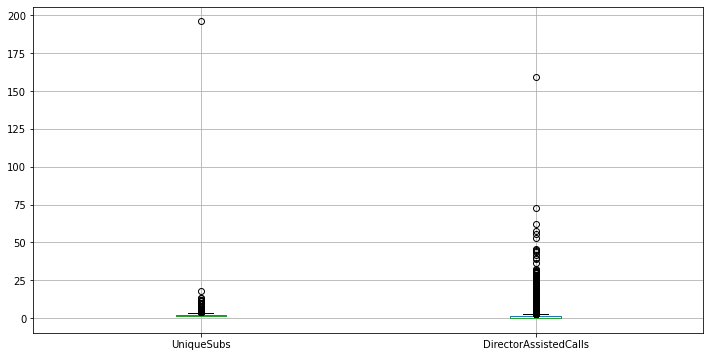

In [9]:
# Plot boxplot 
fig, ax = plt.subplots(figsize = (12,6))
cols = ["UniqueSubs","DirectorAssistedCalls"]
df1.boxplot(column = cols);

In [10]:
# Remove top 1% outliers from the above mentioned two columns and plot the box plot again
# Use "quantile" function to identify top 1% outliers

# Find percentage of quantile
q_high = df1[cols].quantile(0.99)
q_low = df1[cols].quantile(0.01)

# Drop top 1% outliers
df1 = df1[~((df1[cols] < q_low) | (df1[cols] > q_high)).any(axis = 1)]
df1.shape

(50323, 58)

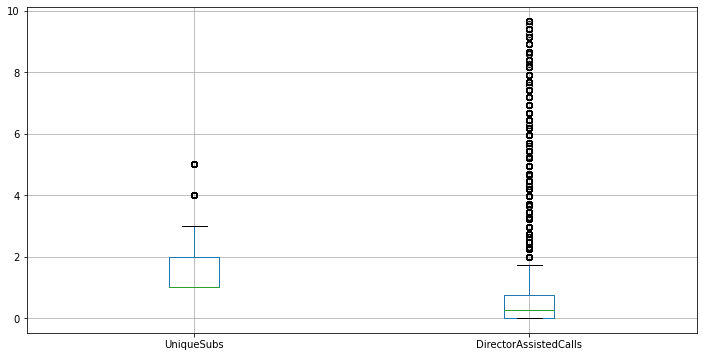

In [11]:
# Plot boxplot to see result after dropping outliers
fig, ax = plt.subplots(figsize = (12,6))
df1.boxplot(column = cols);

<mark>__Actions:__

Outlier indexes have been dropped, 50323 rows remain.

## 3.0. Exploratory analysis to analyze customer churn

### 3.1 Correlation between "OverageMinutes" and "MonthlyRevenue"

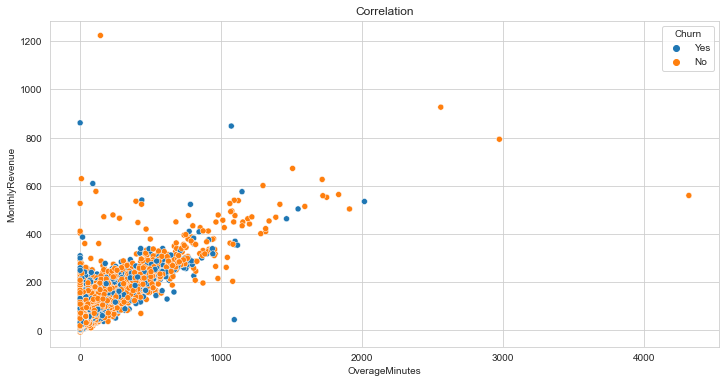

In [12]:
# Use scatter plot to find the correlation 
fig = plt.gcf().set_size_inches(12, 6)
sns.set_style("whitegrid")
sns.scatterplot(x = 'OverageMinutes', y = 'MonthlyRevenue', hue = 'Churn', data = df1, color = 'steelblue')
plt.title("Correlation");

<mark>__Results:__
    
The plot shows positive correlation where most of points are scattered in between range overage minutes (0 - 1000) and monthly revenue (0 - 400). There are also points scattered above average with similar ratio of increase. 

### 3.2 Correlation between "ActiveSubs" and "MonthlyRevenue"

In [13]:
df1.ActiveSubs.value_counts()

1    35887
2    12069
3     1841
4      391
5       96
0       39
Name: ActiveSubs, dtype: int64

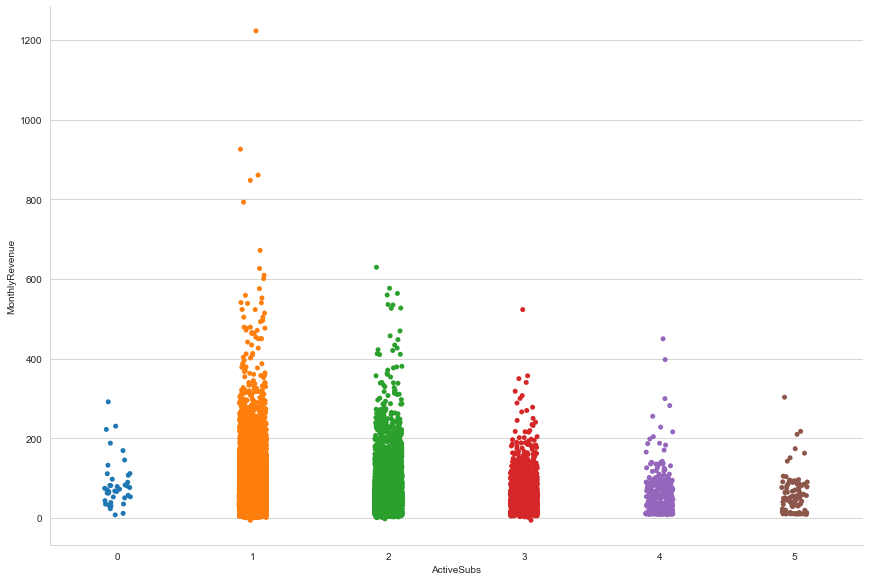

In [14]:
# Use category plot to plot monthly revenue for each active subs category
sns.catplot(x = 'ActiveSubs', y = 'MonthlyRevenue', data = df1, height = 8, aspect = 1.5);

<mark>__Results:__
    
A high number of active subscribers is correlated with low monthly revenue, where the negative correlation is exited when the number of ActiveSubs increases while the monthly revenue decreases. 

### 3.3 Does credit rating have an impact in churn rate?

In [15]:
# Crosstab credit rating and churn rate
credit_rating_rate = pd.crosstab(df1.CreditRating,df1.Churn).apply(lambda r: r / r.sum(), axis = 1)
credit_rating_rate

credit_rating_count = pd.crosstab(df1.CreditRating,df1.Churn)
credit_rating_count

Churn,No,Yes
CreditRating,,
1-Highest,0.692216,0.307784
2-High,0.699421,0.300579
3-Good,0.689493,0.310507
4-Medium,0.739015,0.260985
5-Low,0.778388,0.221612
6-VeryLow,0.730317,0.269683
7-Lowest,0.710263,0.289737


Churn,No,Yes
CreditRating,,
1-Highest,5780,2570
2-High,13175,5662
3-Good,5709,2571
4-Medium,3902,1378
5-Low,4963,1413
6-VeryLow,807,298
7-Lowest,1488,607


<Figure size 864x432 with 0 Axes>

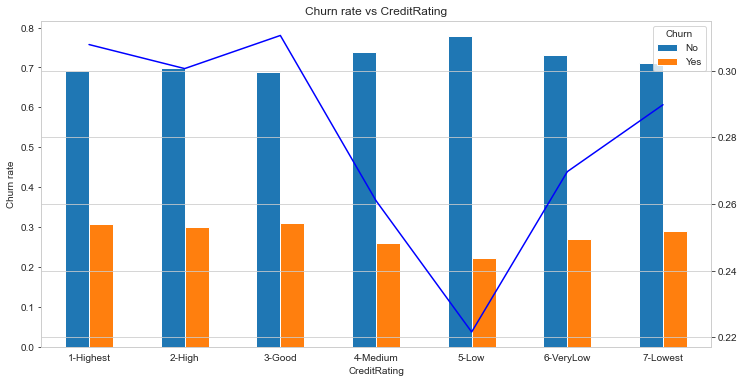

In [16]:
fig = plt.gcf().set_size_inches(12, 6)
credit_rating_rate.plot.bar(stacked = False,figsize = (12,6),ylabel = "Churn rate", 
                            title = 'Churn rate vs CreditRating')
credit_rating_rate.Yes.plot(color = 'blue',secondary_y = True);

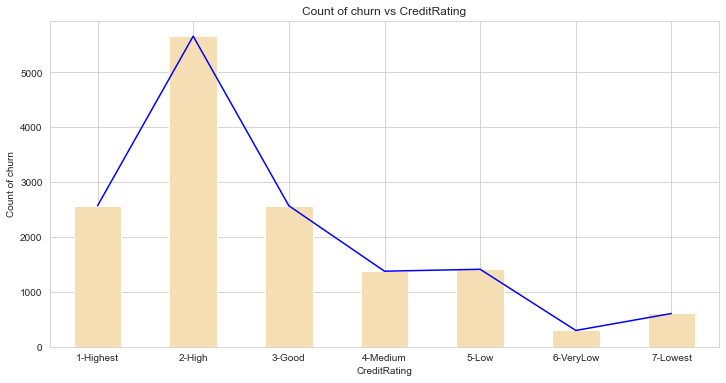

In [17]:
credit_rating_count.Yes.plot.bar(stacked = False,figsize = (12,6),ylabel = "Count of churn", 
                                 title = 'Count of churn vs CreditRating', color = 'wheat')
credit_rating_count.Yes.plot(color = 'blue');

<mark>__Results:__
    
Aside from credit rating 1 being the highest, the plots above show a correlation between credit rating and churn rate, with high credit rating correlated with high churn rate; low credit rating correlated with low churn rate, with 2 being high and 5 being low.
    
In addition, we should not ignore the last two credit ratings (even though a small portion is in the dataset), 6 being very low and 7 being the lowest since that corresponds to a low credit rating and a high churn rate. 

## 4.0 Features engineering

In [18]:
# Wrapper function to create additional features for churn prediction
# Make a call to the feature engineering wrapper function for churn prediction

def create_features(df1):
    
    # Percent of current active subs over total subs
    df1['perc_active_subs'] = df1['ActiveSubs'] / df1['UniqueSubs'] * 100
    
    # Percent of recurrent charge to monthly charge
    df1['perc_recurrent_charge'] = df1['TotalRecurringCharge'] / df1['MonthlyRevenue'] * 100
    
    # Percent of overage minutes over total monthly minutes
    df1['perc_overage_minutes'] = df1['OverageMinutes'] / df1['MonthlyMinutes'] * 100
  
    return df1

create_features(df1)

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,perc_active_subs,perc_recurrent_charge,perc_overage_minutes
0,3000002,Yes,24.00000,219.000000,22.00000,0.250000,0.000000,0.00000,-157.00000,-19.000000,0.7,0.7,6.3,0.0,0.0,97.2,0.0,0.0,58.0,24.0,1.3,0.0,0.3,61,2,1,SEAPOR503,2.0,2.0,361.0,62.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,1,0,No,No,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No,50.0,91.666667,0.000000
1,3000010,Yes,16.99000,10.000000,17.00000,0.000000,0.000000,0.00000,-4.00000,0.000000,0.3,0.0,2.7,0.0,0.0,0.0,0.0,0.0,5.0,1.0,0.3,0.0,0.0,58,1,1,PITHOM412,2.0,1.0,1504.0,40.0,42.0,Yes,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,Yes,No,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes,100.0,100.058858,0.000000
2,3000014,No,38.00000,8.000000,38.00000,0.000000,0.000000,0.00000,-2.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.4,0.3,0.0,1.3,3.7,0.0,0.0,0.0,60,1,1,MILMIL414,1.0,1.0,1812.0,26.0,26.0,Yes,No,No,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes,100.0,100.000000,0.000000
3,3000022,No,82.28000,1312.000000,75.00000,1.240000,0.000000,0.00000,157.00000,8.100000,52.0,7.7,76.0,4.3,1.3,200.3,370.3,147.0,555.7,303.7,59.7,0.0,22.7,59,2,2,PITHOM412,9.0,4.0,458.0,30.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,Yes,No,0,6,No,0,10,No,4-Medium,Other,Other,No,100.0,91.152163,0.000000
4,3000026,Yes,17.14000,0.000000,17.00000,0.000000,0.000000,0.00000,0.00000,-0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53,2,2,OKCTUL918,4.0,3.0,852.0,46.0,54.0,No,No,No,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,Yes,0,9,No,1,10,No,1-Highest,Other,Professional,Yes,100.0,99.183197,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,3399958,Yes,58.84143,525.712744,46.83502,0.895335,40.032505,1.23639,-11.54882,-1.192079,9.3,2.7,48.3,0.0,0.0,58.9,17.0,1.3,160.3,33.3,12.0,0.0,0.3,29,1,1,LAXSFN818,2.0,2.0,526.0,68.0,64.0,No,Yes,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,No,0,6,No,0,60,No,1-Highest,Suburban,Other,Yes,100.0,79.595313,7.614901
51043,3399974,No,95.17000,1745.000000,85.00000,0.990000,45.000000,4.70000,122.00000,15.900000,16.7,0.7,41.3,0.0,0.0,681.5,89.7,33.3,318.7,248.3,17.3,0.0,14.3,29,1,1,LAXCDG310,2.0,2.0,464.0,48.0,48.0,Yes,No,Yes,No,No,Known,Yes,Yes,No,No,Yes,Yes,0,0,No,No,0,9,No,1,60,No,3-Good,Other,Other,No,100.0,89.313859,2.578797
51044,3399978,Yes,58.84143,525.712744,46.83502,0.895335,40.032505,1.23639,-11.54882,-1.192079,71.7,4.3,287.0,1.3,13.7,1225.3,430.3,87.7,1359.0,910.3,76.0,0.0,6.7,25,1,1,LAXCDG310,3.0,2.0,378.0,36.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,No,Yes,0,0,No,No,0,7,No,1,80,No,5-Low,Other,Clerical,No,100.0,79.595313,7.614901
51045,3399990,No,58.84143,525.712744,46.83502,0.895335,40.032505,1.23639,-11.54882,-1.192079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,1,1,NEVPOW619,2.0,2.0,433.0,32.0,0.0,Yes,No,Yes,No,No,Unknown,No,No,No,No,No,No,0,0,No,No,0,9,No,0,30,No,5-Low,Other,Other,No,100.0,79.595313,7.614901


In [19]:
# Treat null values with mean
df1.fillna(df1.mean(),inplace = True)

## 5.0 Additional exploratory data analysis

In [20]:
# Convert 'Churn' into Yes=1, No=0 for numerical variables analysis
df1['Churn'] = np.where(df1['Churn'] == 'Yes', 1, 0)

#### Initial numerical list

In [21]:
# Create a list of numeric variables based on int dtype
num_type = ['int32','int64','float64']
print(list(df1.select_dtypes(include = num_type)))

['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes', 'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues', 'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls', 'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls', 'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls', 'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService', 'UniqueSubs', 'ActiveSubs', 'Handsets', 'HandsetModels', 'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'RetentionCalls', 'RetentionOffersAccepted', 'ReferralsMadeBySubscriber', 'IncomeGroup', 'AdjustmentsToCreditRating', 'perc_active_subs', 'perc_recurrent_charge', 'perc_overage_minutes']


In [22]:
num_col = ['CustomerID','MonthlyRevenue','MonthlyMinutes','TotalRecurringCharge','DirectorAssistedCalls',
            'OverageMinutes','RoamingCalls', 'PercChangeMinutes','PercChangeRevenues','DroppedCalls','BlockedCalls',
            'UnansweredCalls','CustomerCareCalls','ThreewayCalls', 'ReceivedCalls','OutboundCalls','InboundCalls', 'PeakCallsInOut',
            'OffPeakCallsInOut','DroppedBlockedCalls','CallForwardingCalls','CallWaitingCalls','MonthsInService','UniqueSubs',
            'ActiveSubs','Handsets','HandsetModels','CurrentEquipmentDays','AgeHH1', 'AgeHH2','RetentionCalls',
            'RetentionOffersAccepted','ReferralsMadeBySubscriber','IncomeGroup','AdjustmentsToCreditRating', 'perc_active_subs',
            'perc_recurrent_charge', 'perc_overage_minutes']

In [23]:
# Explore numerical variables
print(round(df1[num_col].describe()),2)

       CustomerID  MonthlyRevenue  MonthlyMinutes  TotalRecurringCharge  \
count     50323.0         50323.0         50323.0               50323.0   
mean    3201948.0            58.0           515.0                  46.0   
std      116810.0            42.0           510.0                  23.0   
min     3000002.0            -6.0             0.0                 -11.0   
25%     3100750.0            34.0           157.0                  30.0   
50%     3201542.0            48.0           364.0                  45.0   
75%     3305244.0            70.0           707.0                  60.0   
max     3399994.0          1223.0          6336.0                 360.0   

       DirectorAssistedCalls  OverageMinutes  RoamingCalls  PercChangeMinutes  \
count                50323.0         50323.0       50323.0            50323.0   
mean                     1.0            38.0           1.0              -11.0   
std                      1.0            92.0           9.0              251.0   


In [24]:
# Visualize numeric variables distribution and outlier using violin plot

def plot_violin(df, cols, col_x = 'Churn'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.violinplot(x=col_x, y=col, data=df)
        plt.xlabel(col_x) # Set text for the x axis
        plt.ylabel(col)   # Set text for y axis
        plt.show()

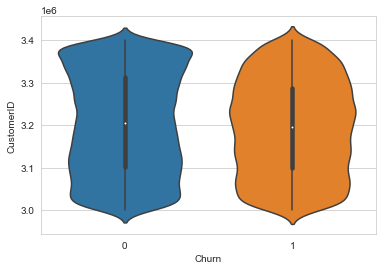

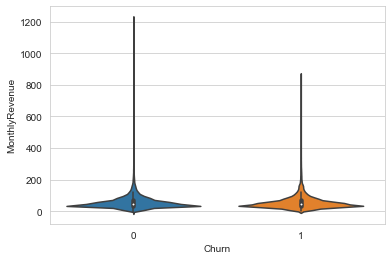

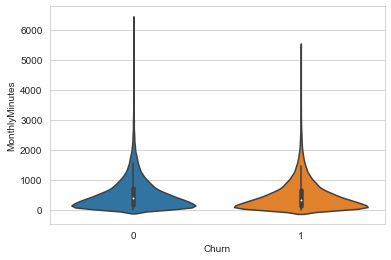

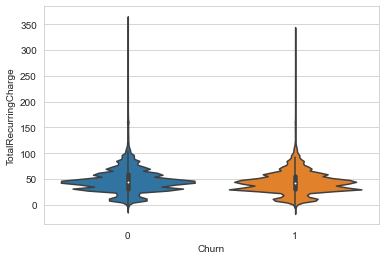

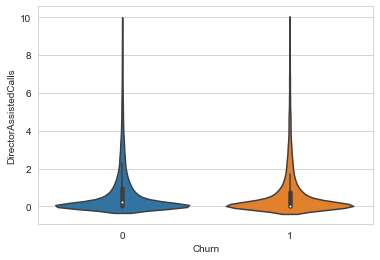

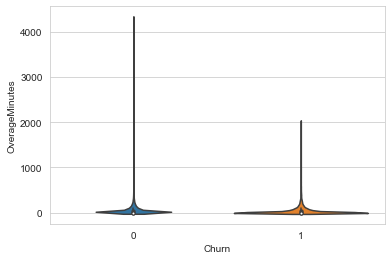

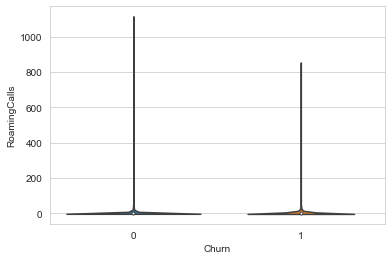

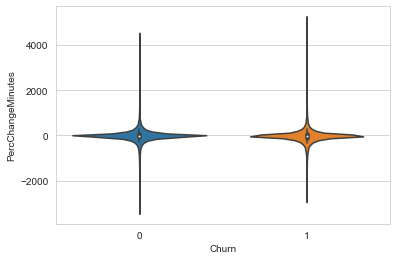

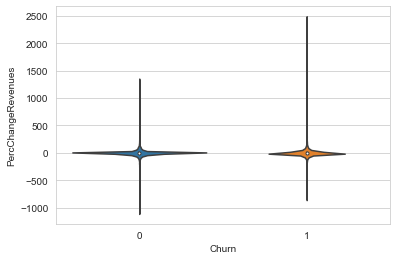

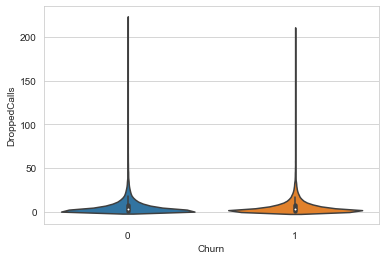

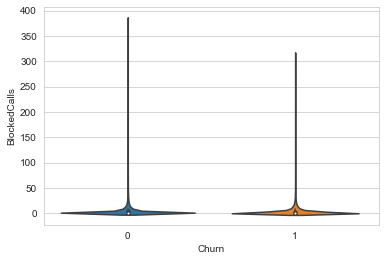

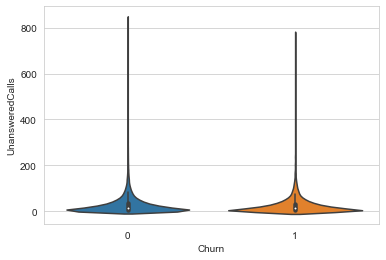

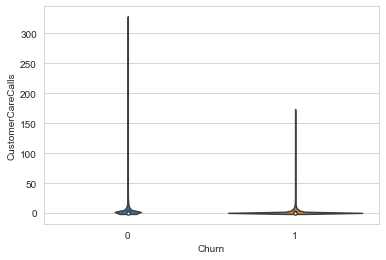

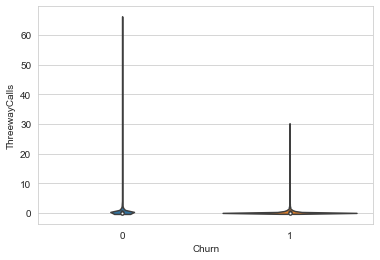

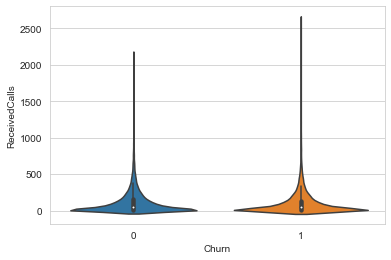

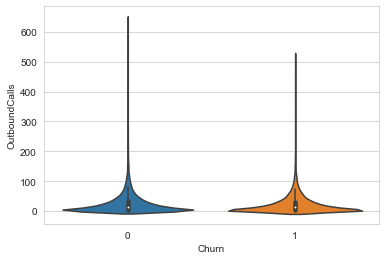

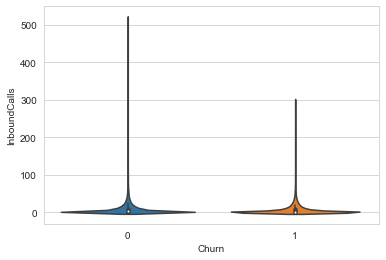

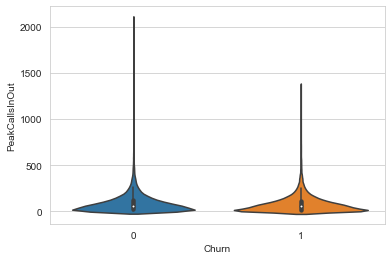

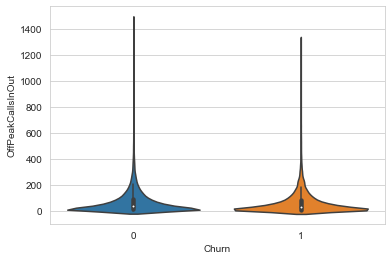

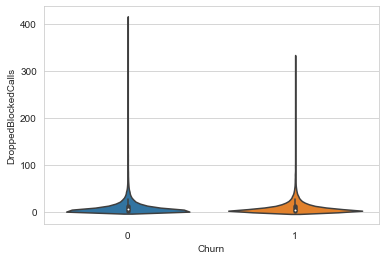

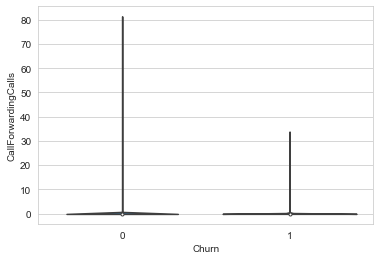

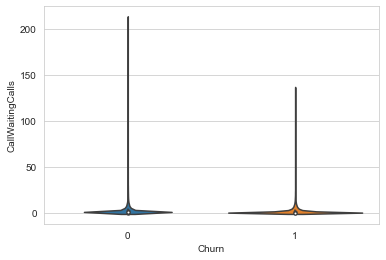

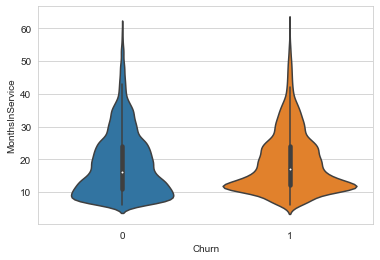

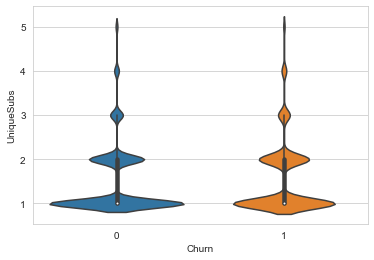

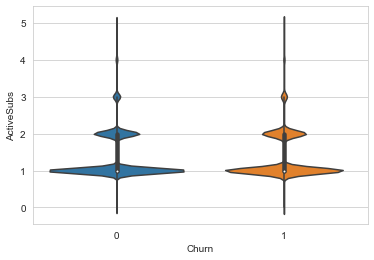

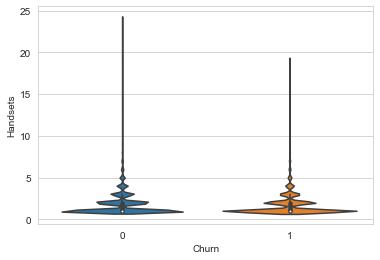

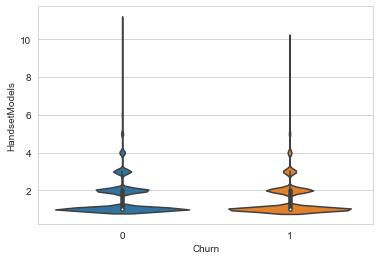

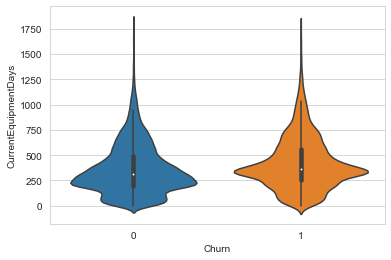

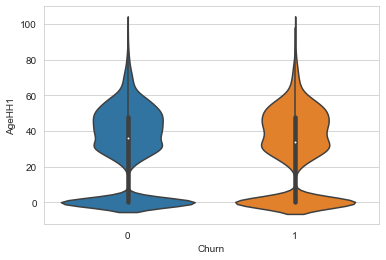

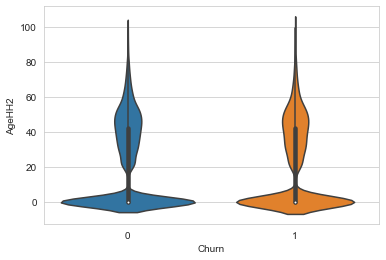

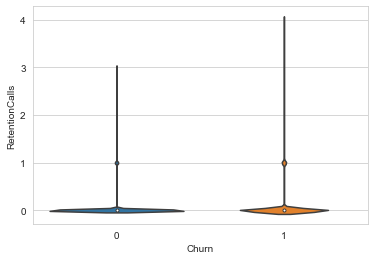

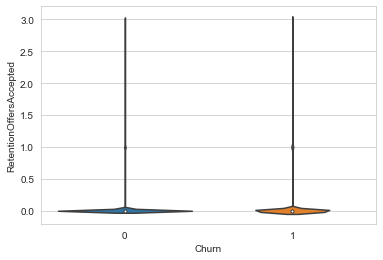

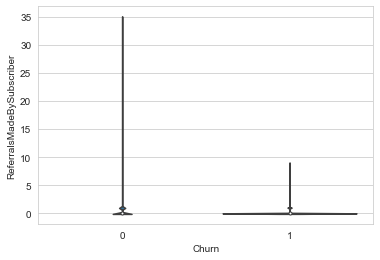

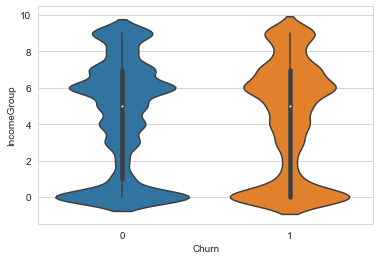

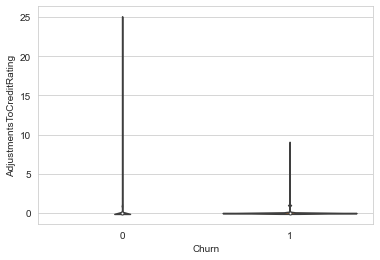

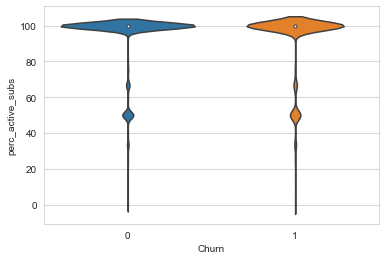

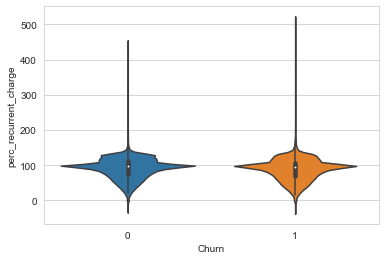

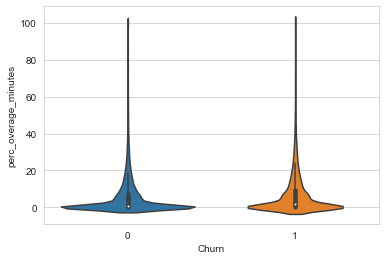

In [25]:
plot_violin(df1,num_col)

<mark>__Results:__
    
Most of the variables appear right/positively skewed with outliers suggest to use "Kendall" method for correlation comparison.

In [26]:
# Check top variables that are correlated with churn rate
df1.corr(method = 'kendall', min_periods = 1)["Churn"].sort_values(ascending = False) * 100

Churn                        100.000000
CurrentEquipmentDays           9.561276
RetentionCalls                 6.763586
perc_overage_minutes           4.576552
UniqueSubs                     4.105795
RetentionOffersAccepted        3.595232
MonthsInService                3.303644
ActiveSubs                     1.980748
OverageMinutes                 1.936249
RoamingCalls                   0.174623
CallForwardingCalls           -0.467163
PercChangeRevenues            -0.481330
IncomeGroup                   -0.939632
ReferralsMadeBySubscriber     -0.940105
BlockedCalls                  -1.458581
AdjustmentsToCreditRating     -1.525300
AgeHH2                        -1.619471
MonthlyRevenue                -1.761200
DirectorAssistedCalls         -2.007369
DroppedCalls                  -2.051007
DroppedBlockedCalls           -2.233887
AgeHH1                        -2.660699
ThreewayCalls                 -2.825745
CallWaitingCalls              -3.332492
Handsets                      -3.378305


In [27]:
# Check churn rate for each variables
churn_rate_num = df1.groupby('Churn').sum().apply(lambda r: r/r.sum(), axis=0)
churn_rate_num.transpose()

Churn,0,1
CustomerID,0.712561,0.287439
MonthlyRevenue,0.715310,0.284690
MonthlyMinutes,0.733810,0.266190
TotalRecurringCharge,0.725344,0.274656
DirectorAssistedCalls,0.727135,0.272865
OverageMinutes,0.691728,0.308272
RoamingCalls,0.676144,0.323856
PercChangeMinutes,0.370841,0.629159
PercChangeRevenues,0.873810,0.126190
DroppedCalls,0.721409,0.278591


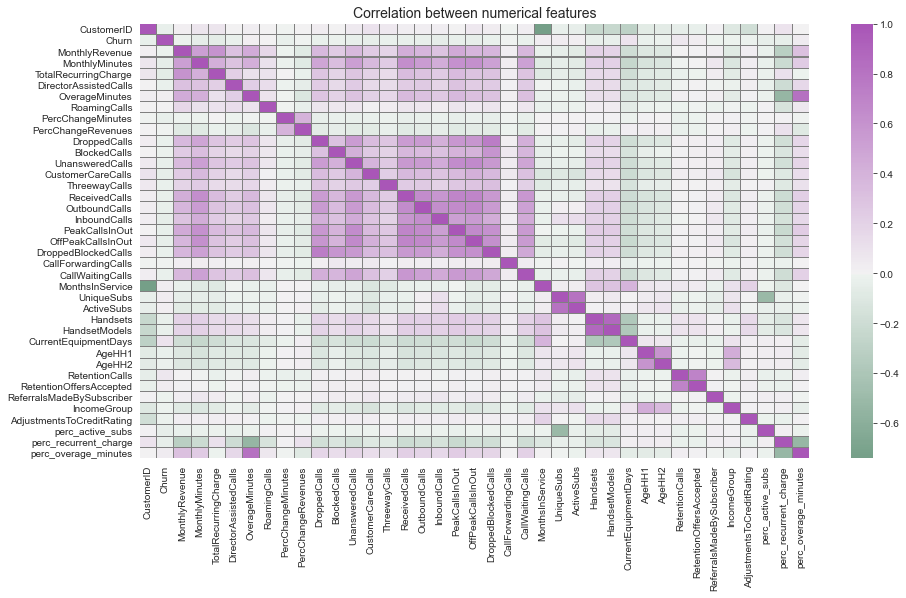

In [28]:
# Plot correlation
fig, ax = plt.subplots(figsize = (15,8))
mycmap = sns.diverging_palette(145, 300, s = 60, as_cmap = True)
sns.heatmap(data = df1.corr('kendall', min_periods = 1), center = 0.0, square = False, cmap = mycmap, linewidths = 0.01, 
            linecolor = 'gray')
plt.title("Correlation between numerical features", y = 1, size = 14);

#### Initial categorical list

In [31]:
# Create a list of categorical variables based on object dtype
cat_type = ['object']
print(list(df1.select_dtypes(include = cat_type)))

['ServiceArea', 'ChildrenInHH', 'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'HandsetPrice', 'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation', 'MaritalStatus']


In [32]:
cat_col = ['Churn','ServiceArea', 'ChildrenInHH', 'HandsetRefurbished',
       'HandsetWebCapable', 'TruckOwner', 'RVOwner', 'Homeownership',
       'BuysViaMailOrder', 'RespondsToMailOffers', 'OptOutMailings',
       'NonUSTravel', 'OwnsComputer', 'HasCreditCard', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'OwnsMotorcycle', 'HandsetPrice',
       'MadeCallToRetentionTeam', 'CreditRating', 'PrizmCode', 'Occupation',
       'MaritalStatus']

In [33]:
# Check for cardinality 
for var in cat_col: 
    print(var, 'contains',len(df1[var].unique()),'labels')

Churn contains 2 labels
ServiceArea contains 746 labels
ChildrenInHH contains 2 labels
HandsetRefurbished contains 2 labels
HandsetWebCapable contains 2 labels
TruckOwner contains 2 labels
RVOwner contains 2 labels
Homeownership contains 2 labels
BuysViaMailOrder contains 2 labels
RespondsToMailOffers contains 2 labels
OptOutMailings contains 2 labels
NonUSTravel contains 2 labels
OwnsComputer contains 2 labels
HasCreditCard contains 2 labels
NewCellphoneUser contains 2 labels
NotNewCellphoneUser contains 2 labels
OwnsMotorcycle contains 2 labels
HandsetPrice contains 16 labels
MadeCallToRetentionTeam contains 2 labels
CreditRating contains 7 labels
PrizmCode contains 4 labels
Occupation contains 8 labels
MaritalStatus contains 3 labels


In [34]:
# View frequency distribution
for var in cat_col:   
    print(df1[var].value_counts() / np.float(len(df1)))

0    0.711881
1    0.288119
Name: Churn, dtype: float64
NYCBRO917    0.033186
HOUHOU281    0.029430
DALDAL214    0.029231
NYCMAN917    0.023190
APCFCH703    0.015460
               ...   
INDCRA765    0.000020
STLPIT316    0.000020
MILLKM920    0.000020
NOLPOH504    0.000020
MILWAT920    0.000020
Name: ServiceArea, Length: 745, dtype: float64
No     0.757685
Yes    0.242315
Name: ChildrenInHH, dtype: float64
No     0.861733
Yes    0.138267
Name: HandsetRefurbished, dtype: float64
Yes    0.901496
No     0.098504
Name: HandsetWebCapable, dtype: float64
No     0.813286
Yes    0.186714
Name: TruckOwner, dtype: float64
No     0.918785
Yes    0.081215
Name: RVOwner, dtype: float64
Known      0.666971
Unknown    0.333029
Name: Homeownership, dtype: float64
No     0.637541
Yes    0.362459
Name: BuysViaMailOrder, dtype: float64
No     0.62236
Yes    0.37764
Name: RespondsToMailOffers, dtype: float64
No     0.985136
Yes    0.014864
Name: OptOutMailings, dtype: float64
No     0.943366
Yes    0.05

In [35]:
# Visualize categorical variables with more predictive factor using bar plot

def plot_count(df, cols, col_x = 'Churn'):
    for col in cols:
        sns.set_style("whitegrid")
        sns.countplot(x=col, data=df, hue='Churn', palette='BuGn', linewidth=0.4, edgecolor='black')
        plt.xlabel(col)     # Set text for the x axis
        plt.ylabel('Count') # Set text for y axis
        plt.show()

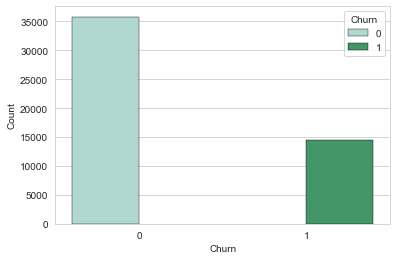

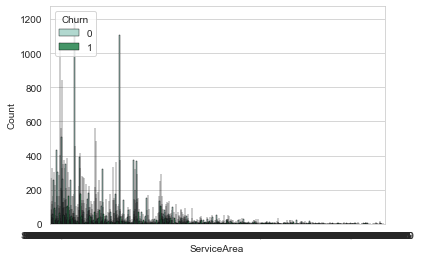

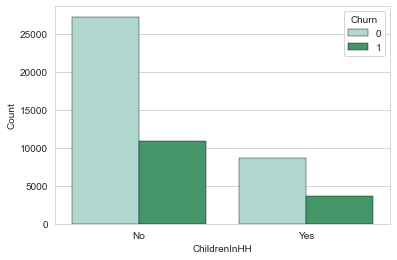

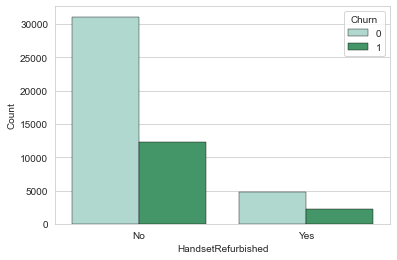

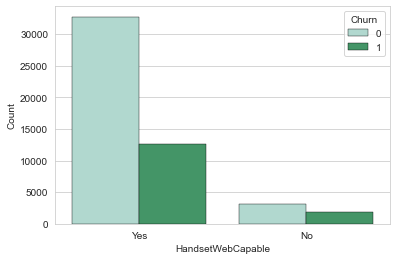

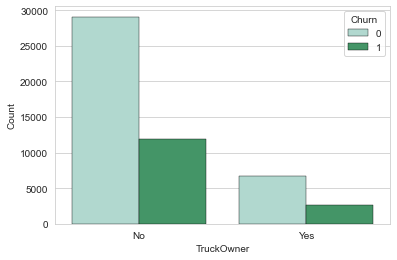

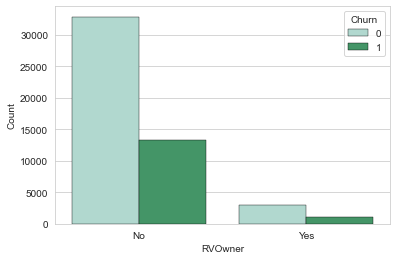

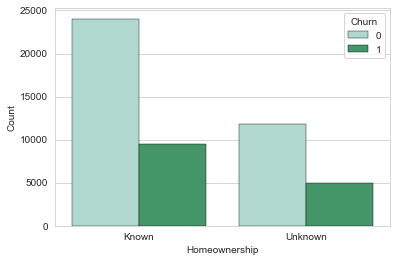

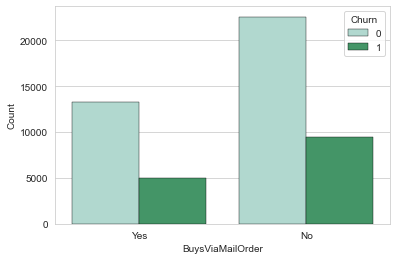

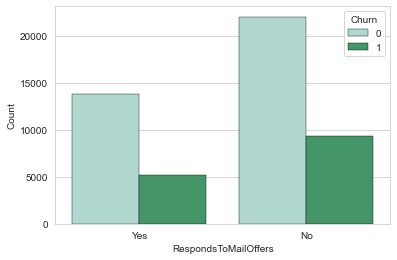

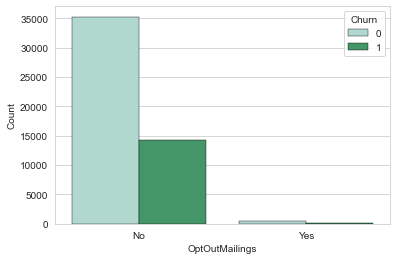

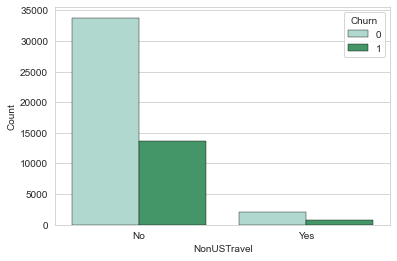

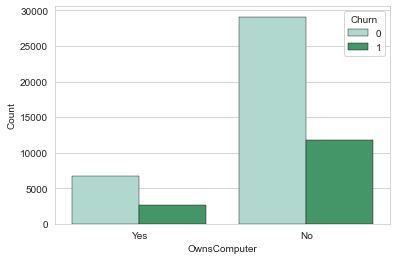

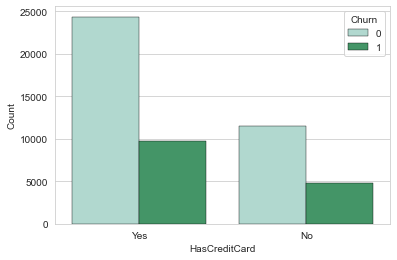

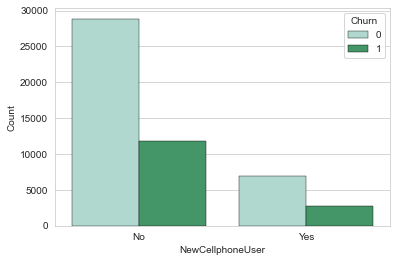

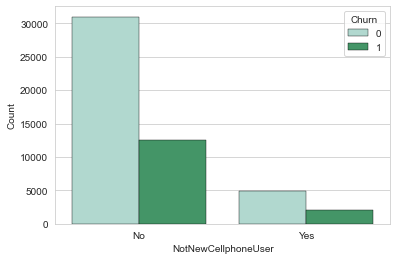

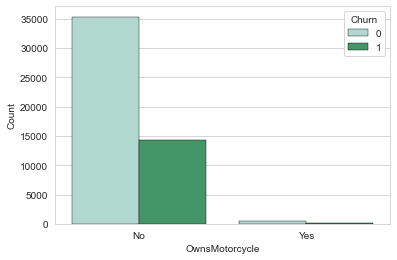

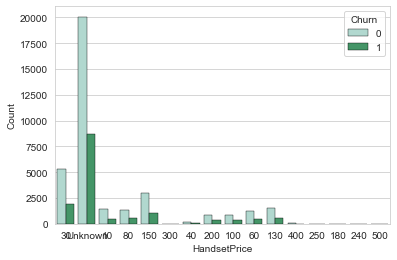

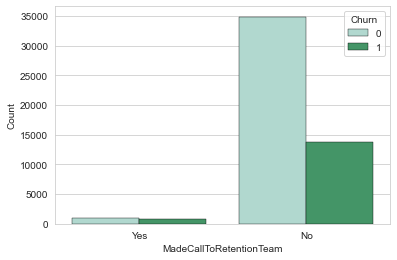

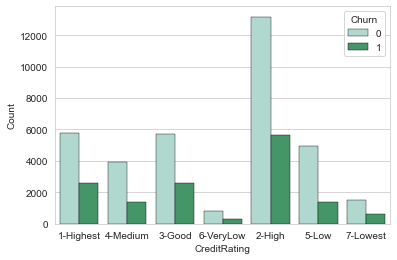

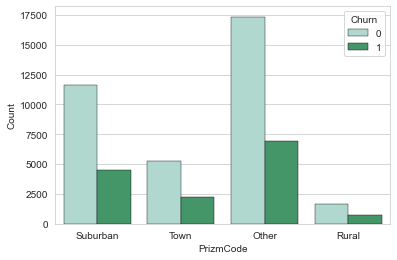

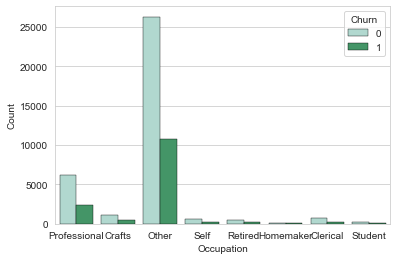

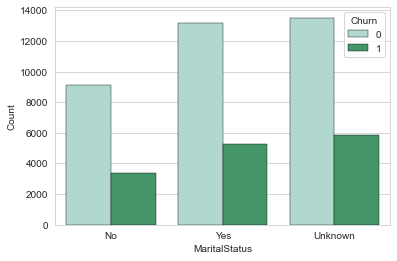

In [36]:
plot_count(df1,cat_col)

In [37]:
# Label-encoding for correlation calculation
cat_col_factorize = df1[cat_col].apply(lambda x : pd.factorize(x)[0])
cat_col_factorize

,Churn,ServiceArea,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
2,1,2,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,1,1,2,1,1,1
3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,1,1,2,2,0
4,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,0,261,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,9,1,0,0,2,1
51043,1,243,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,2,2,2,0
51044,0,243,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,3,1,5,2,6,0
51045,1,273,1,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,1,5,2,2,0


In [38]:
print('Special note: 0 = Churn, 1 = Non-churn after label-encoding')
cat_col_factorize

Special note: 0 = Churn, 1 = Non-churn after label-encoding


,Churn,ServiceArea,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,NewCellphoneUser,NotNewCellphoneUser,OwnsMotorcycle,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
2,1,2,1,0,1,0,0,1,1,1,0,0,1,0,1,0,0,1,1,2,1,1,1
3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,2,1,1,2,2,0
4,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,1,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,0,261,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,9,1,0,0,2,1
51043,1,243,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,1,2,2,2,0
51044,0,243,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,3,1,5,2,6,0
51045,1,273,1,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,1,5,2,2,0


In [39]:
# Check cat_col_factorize that are correlated with churn rate
# Pre-overview for filter-based features selection
cat_col_factorize.corr(method = 'kendall', min_periods = 1)["Churn"].sort_values(ascending = False) * 100

Churn                      100.000000
MadeCallToRetentionTeam      6.770909
CreditRating                 2.623728
HandsetPrice                 0.914239
NewCellphoneUser             0.726666
TruckOwner                   0.576099
RVOwner                      0.426325
NonUSTravel                  0.363305
OptOutMailings              -0.017665
ServiceArea                 -0.320320
OwnsComputer                -0.332898
Occupation                  -0.484308
NotNewCellphoneUser         -0.629978
OwnsMotorcycle              -0.645522
PrizmCode                   -0.788092
ChildrenInHH                -0.877382
HasCreditCard               -0.877815
Homeownership               -1.344530
BuysViaMailOrder            -2.348426
RespondsToMailOffers        -2.456450
MaritalStatus               -2.529010
HandsetRefurbished          -2.977932
HandsetWebCapable           -6.181208
Name: Churn, dtype: float64

In [40]:
# Check churn rate for each variables
churn_rate_cat = cat_col_factorize.groupby('Churn').sum().apply(lambda r: r/r.sum(), axis=0)
churn_rate_cat.transpose()

Churn,0,1
ServiceArea,0.287110,0.712890
ChildrenInHH,0.295145,0.704855
HandsetRefurbished,0.321788,0.678212
HandsetWebCapable,0.372806,0.627194
TruckOwner,0.282673,0.717327
RVOwner,0.281625,0.718375
Homeownership,0.296736,0.703264
BuysViaMailOrder,0.296138,0.703862
RespondsToMailOffers,0.296785,0.703215
OptOutMailings,0.288770,0.711230


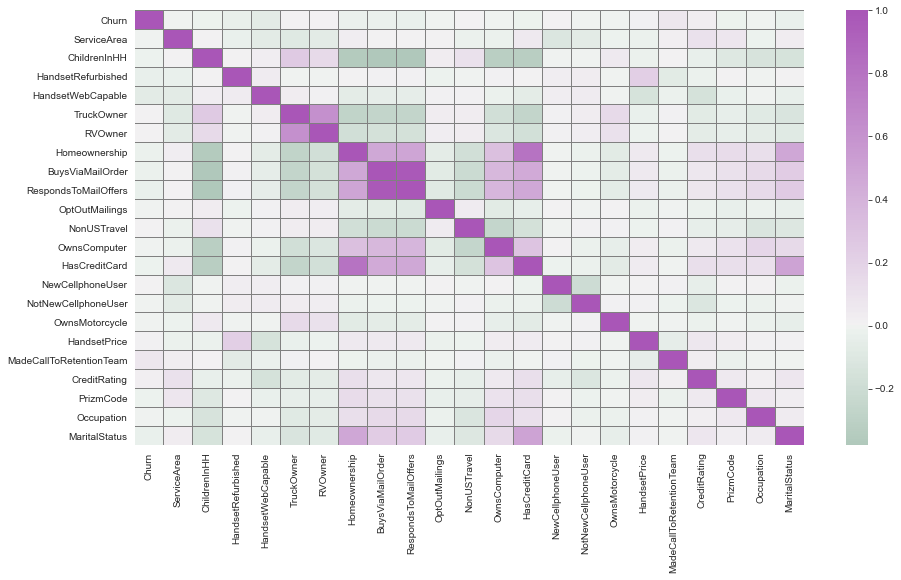

In [41]:
# Plot correlation
fig, ax = plt.subplots(figsize = (15,8))
sns.heatmap(data = cat_col_factorize.corr(), center = 0.0, square = False, cmap = mycmap, linewidths = 0.01, 
            linecolor = 'gray');

## 6.0 Features selection

In [42]:
# Define function for Sequential Selection

sfs = SFS(LogisticRegression(),
          k_features=15,
          forward=True,
          floating=False,
          scoring = 'accuracy',
          cv = 3)

In [43]:
%%time

# Initial Forward Sequential Selection on numeric_features
X_num = df1[num_col]              
y_num = df1['Churn']

sfs.fit(X_num , y_num )
sfs.k_feature_names_

Wall time: 3min 49s


('CustomerID',
 'MonthlyRevenue',
 'MonthlyMinutes',
 'DirectorAssistedCalls',
 'PercChangeMinutes',
 'PercChangeRevenues',
 'DroppedCalls',
 'CustomerCareCalls',
 'OutboundCalls',
 'InboundCalls',
 'OffPeakCallsInOut',
 'HandsetModels',
 'AgeHH2',
 'RetentionCalls',
 'ReferralsMadeBySubscriber')

In [44]:
%%time

# Initial Forward Sequential Selection on categorical_features
X_cat = df1[cat_col]              
y_cat = df1['Churn'] 

sfs.fit(X_cat, y_cat)
sfs.k_feature_names_

Wall time: 7.68 s


('Churn',
 'ServiceArea',
 'ChildrenInHH',
 'HandsetRefurbished',
 'HandsetWebCapable',
 'TruckOwner',
 'RVOwner',
 'Homeownership',
 'BuysViaMailOrder',
 'RespondsToMailOffers',
 'OptOutMailings',
 'NonUSTravel',
 'OwnsComputer',
 'HasCreditCard',
 'NewCellphoneUser')

In [45]:
# Select features based on EDA and Sequential Selection function

sel_num_fea = ['CurrentEquipmentDays','RetentionCalls','perc_overage_minutes','UniqueSubs',
              'MonthsInService','PercChangeMinutes','RoamingCalls',
               'MonthlyRevenue','MonthlyMinutes','DirectorAssistedCalls','PercChangeRevenues','DroppedCalls',
               'CustomerCareCalls','OutboundCalls','InboundCalls', 'OffPeakCallsInOut','HandsetModels',
               'ReferralsMadeBySubscriber']
               
sel_cat_fea = ['ChildrenInHH','HandsetRefurbished','HandsetWebCapable','TruckOwner','Homeownership',
               'RespondsToMailOffers','HasCreditCard','NewCellphoneUser','OwnsMotorcycle','MadeCallToRetentionTeam',
               'Occupation','CreditRating', 'OptOutMailings','NonUSTravel','OwnsComputer', 
               'BuysViaMailOrder']

drop_list = ['CustomerID', 'TotalRecurringCharge','BlockedCalls','UnansweredCalls','ThreewayCalls', 'ReceivedCalls',
             'PeakCallsInOut','DroppedBlockedCalls','CallForwardingCalls','CallWaitingCalls','OverageMinutes',
             'ServiceArea','RetentionOffersAccepted','ActiveSubs','Handsets','AgeHH1','AgeHH2','IncomeGroup',
             'AdjustmentsToCreditRating','perc_active_subs','perc_recurrent_charge','RVOwner',
             'NotNewCellphoneUser','HandsetPrice','PrizmCode','MaritalStatus']

# Drop list
df2 = df1.drop(drop_list,axis = "columns")
df2.shape

(50323, 35)

## 7.0 Random over-sampling for imbalanced classes of target variable

In [46]:
# Check distribution of target variable 
df2['Churn'].value_counts() / len(df2)
df2.Churn.value_counts()

0    0.711881
1    0.288119
Name: Churn, dtype: float64

0    35824
1    14499
Name: Churn, dtype: int64

In [47]:
# Define dataset
class_0 = df2.drop('Churn', axis = 1)
class_1 = df2.Churn     

# Define random oversampling strategy
ros = RandomOverSampler(random_state=42)
class_0_ros, class_1_ros = ros.fit_resample(class_0 , class_1)

# Merge data as rs (resampled dataframe)
rs_df = pd.concat([class_0_ros, class_1_ros], axis=1)

# Check distribution of class after resampling
rs_df['Churn'].value_counts()/len(rs_df['Churn'])
rs_df['Churn'].value_counts()

0    0.5
1    0.5
Name: Churn, dtype: float64

0    35824
1    35824
Name: Churn, dtype: int64

## 8.0 Build classification model to predict customer churn month in advance

### 8.1 Data pre-processing

In [48]:
# Define X and y using rs_df (resampled data)
X = rs_df.drop('Churn', axis = 1)
y = rs_df.Churn

# Scaling for sel_num_fea
sc = StandardScaler()
X_scaled = sc.fit_transform(X[sel_num_fea])
X_scaled = pd.DataFrame(X_scaled, columns = sel_num_fea)

# Get dummy for cat_num_fea
X_dummy = pd.get_dummies(X)
X_dummy.update(X_scaled)

X = X_dummy

# Train-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state =42)

In [49]:
# Check distribution of y_train
y_train.value_counts()
y_test.value_counts()

y_train.value_counts()/len(y_train)
y_test.value_counts()/len(y_test)

# Check train test set shape
X_train.shape
X_test.shape
y_train.shape
y_test.shape

0    25140
1    25013
Name: Churn, dtype: int64

1    10811
0    10684
Name: Churn, dtype: int64

0    0.501266
1    0.498734
Name: Churn, dtype: float64

1    0.502954
0    0.497046
Name: Churn, dtype: float64

(50153, 61)

(21495, 61)

(50153,)

(21495,)

In [50]:
# Define X and y using df2 (non-resampling data)
X_df2 = df2.drop('Churn', axis = 1)
y_df2 = df2.Churn

# Scaling for sel_num_fea
sc = StandardScaler()
X_df2_scaled = sc.fit_transform(X_df2[sel_num_fea])
X_df2_scaled = pd.DataFrame(X_df2_scaled, columns = sel_num_fea)

# Get dummy for cat_num_fea
X_df2_dummy = pd.get_dummies(X_df2)
X_df2_dummy.update(X_df2_scaled)

X_df2 = X_df2_dummy

# Train-split 
X_df2_train, X_df2_test, y_df2_train, y_df2_test = train_test_split(X_df2, y_df2, test_size=0.3, random_state =42)

### 8.2 Build a simple logistic regression model to predict churn and evaluate model accuracy on test data set

#### Machine Learning Utils

In [59]:
# Score matrix

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

def print_metrics(labels, probs, threshold):
    scores = score_model(probs, threshold)
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Actual negative    Actual positive')
    print('Score negative    %6d' % conf[0,0] + '             %5d' % conf[0,1])
    print('Score positive    %6d' % conf[1,0] + '             %5d' % conf[1,1])
    print('')
    print('Accuracy        %0.2f' % sklm.accuracy_score(labels, scores))
    print('AUC             %0.2f' % sklm.roc_auc_score(labels, probs[:,1]))
    print('Macro precision %0.2f' % float((float(metrics[0][0]) + float(metrics[0][1]))/2.0))
    print('Macro recall    %0.2f' % float((float(metrics[1][0]) + float(metrics[1][1]))/2.0))
    print(' ')
    print('           Negative     Positive')
    print('Num case   %6d'   % metrics[3][0] + '        %6d' % metrics[3][1])
    print('Precision  %6.2f' % metrics[0][0] + '        %6.2f' % metrics[0][1])
    print('Recall     %6.2f' % metrics[1][0] + '        %6.2f' % metrics[1][1])
    print('F1         %6.2f' % metrics[2][0] + '        %6.2f' % metrics[2][1])

def plot_auc(labels, probs):
    ## Compute the false positive rate, true positive rate
    ## and threshold along with the AUC
    fpr, tpr, threshold = sklm.roc_curve(labels, probs[:,1])
    auc = sklm.auc(fpr, tpr)
    
    ## Plot the result
    plt.figure(figsize=(10,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show() 
    
def get_count_confusion_metrics(model, x , y):
    
    plot_confusion_matrix(model, x , y)  
    fig = plt.gcf().set_size_inches(12, 6)

LogisticRegression(random_state=42)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative      6286              4398
Score positive      4523              6288

Accuracy        0.58
AUC             0.61
Macro precision 0.58
Macro recall    0.58
 
           Negative     Positive
Num case    10684         10811
Precision    0.58          0.59
Recall       0.59          0.58
F1           0.58          0.59


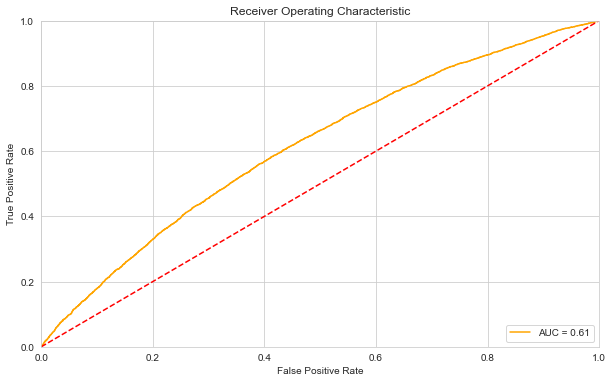

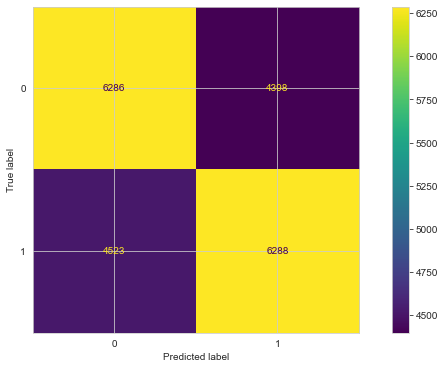

In [61]:
#----------------------- Model training with resampled data------------------------#

# Train a logistic regression model on the training set
# Initialize the Logistic regression
log_clf = LogisticRegression(random_state = 42)

# Fit the training data
log_clf.fit(X_train, y_train)

#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_log_clf = log_clf.predict(X_test)

#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = log_clf.predict_proba(X_test)

# Display AUC and confusion matrix
print_metrics((y_test == 1), probabilities, 0.5)  

plot_auc((y_test == 1), probabilities)

get_count_confusion_metrics(log_clf,X_test,y_test)

LogisticRegression(random_state=42)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative     10733                39
Score positive      4302                23

Accuracy        0.71
AUC             0.57
Macro precision 0.54
Macro recall    0.50
 
           Negative     Positive
Num case    10772          4325
Precision    0.71          0.37
Recall       1.00          0.01
F1           0.83          0.01


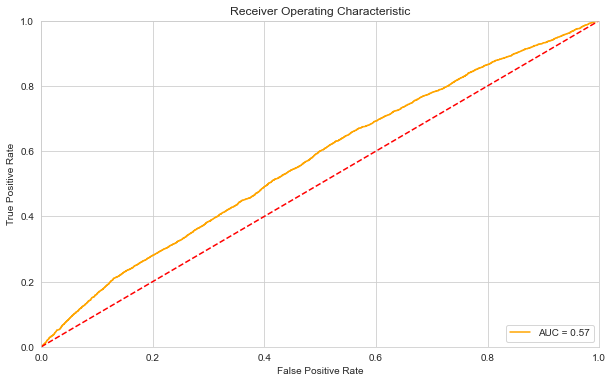

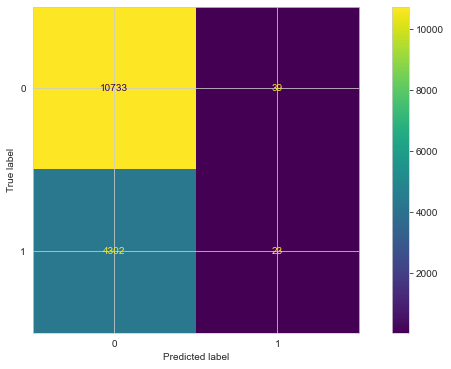

In [62]:
#----------------------Model training with non-resampled data----------------------#

# Train a logistic regression model on the training set
# Initialize the Logistic regression
log_clf_df2 = LogisticRegression(random_state = 42)

# Fit the training data
log_clf_df2.fit(X_df2_train, y_df2_train)

#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_df2_log_clf = log_clf_df2.predict(X_df2_test)

#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = log_clf_df2.predict_proba(X_df2_test)

# Display AUC and confusion matrix
print_metrics((y_df2_test == 1), probabilities, 0.5)  

plot_auc((y_df2_test == 1), probabilities)

get_count_confusion_metrics(log_clf_df2,X_df2_test,y_df2_test)

### 8.3 Build Random Forest classifier to compare model accuracy over the logistic regression model

RandomForestClassifier(random_state=42)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative      9240              1444
Score positive      1587              9224

Accuracy        0.86
AUC             0.93
Macro precision 0.86
Macro recall    0.86
 
           Negative     Positive
Num case    10684         10811
Precision    0.85          0.86
Recall       0.86          0.85
F1           0.86          0.86


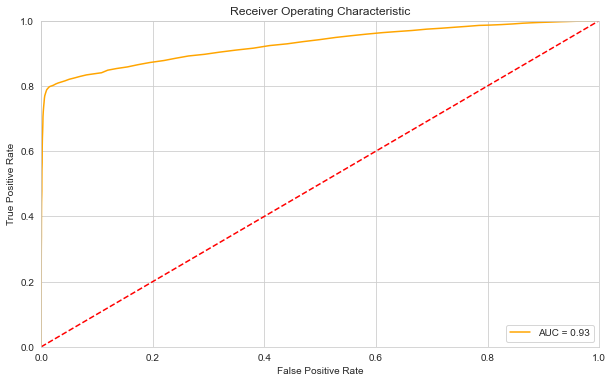

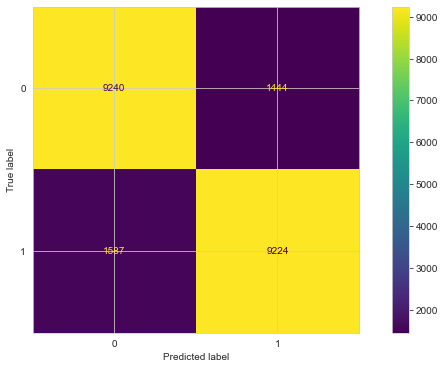

In [63]:
#---------------------- Model training with resampled data-----------------------#

# Train random forest classifier model on training data set
# Initialize randomforest classifier
rf_clf = RandomForestClassifier(random_state = 42)

# Fit the training data
rf_clf.fit(X_train, y_train)

#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_rf_clf = rf_clf.predict(X_test)

#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = rf_clf.predict_proba(X_test)

# Display AUC and confusion matrix
print_metrics((y_test == 1), probabilities, 0.5)  

plot_auc((y_test == 1), probabilities)

get_count_confusion_metrics(rf_clf,X_test,y_test)

RandomForestClassifier(random_state=42)

                 Confusion matrix
                 Actual negative    Actual positive
Score negative     10612               160
Score positive      4231                94

Accuracy        0.71
AUC             0.55
Macro precision 0.54
Macro recall    0.50
 
           Negative     Positive
Num case    10772          4325
Precision    0.71          0.37
Recall       0.99          0.02
F1           0.83          0.04


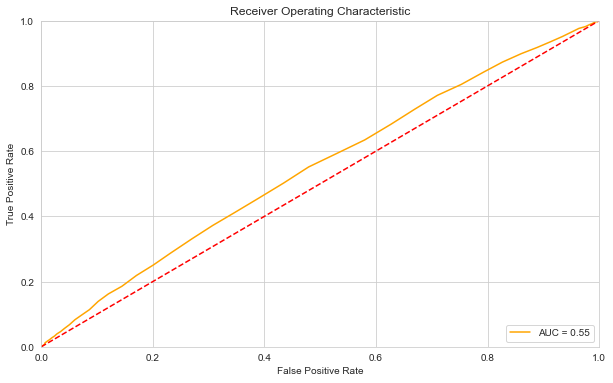

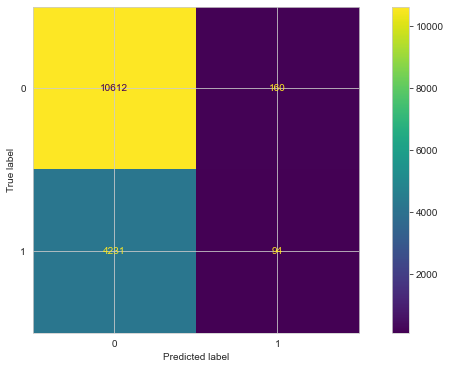

In [64]:
#------------------------- Model training with non-resampled data-------------------------#

# Train random forest classifier model on training data set
# Initialize randomforest classifier
rf_clf_df2 = RandomForestClassifier(random_state = 42)

# Fit the training data
rf_clf_df2.fit(X_df2_train, y_df2_train)

#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_df2_rf_clf = rf_clf_df2.predict(X_df2_test)

#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = rf_clf_df2.predict_proba(X_df2_test)

# Display AUC and confusion matrix
print_metrics((y_df2_test == 1), probabilities, 0.5)  

plot_auc((y_df2_test == 1), probabilities)

get_count_confusion_metrics(rf_clf_df2,X_df2_test,y_df2_test)

<mark>__Results:__

RandomForest classifier model with resampled data shows highest score matrix among the comparisons with accuracy at 0.86 and ROC at 0.93.

### 8.4 Identify important features impacting churn

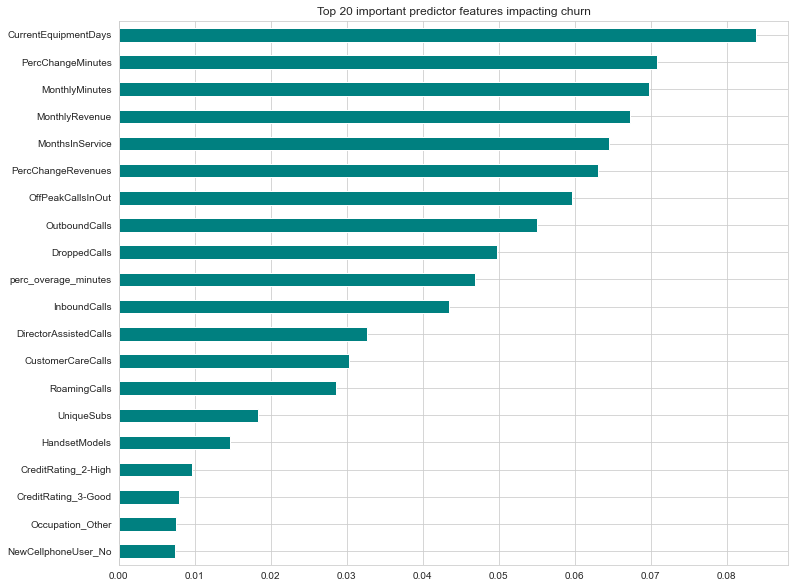

In [65]:
# Plot the top 20 important predictor features impacting churn using the RandomForest Classifier model
importance = rf_clf.feature_importances_

pd.Series(importance, index = X_train.columns).nlargest(20).sort_values(ascending = True).plot(kind = 'barh', 
                                figsize = (12,10), title = 'Top 20 important predictor features impacting churn', 
                                color = 'teal');

In [66]:
pd.Series(importance, index = X.columns).nlargest(20).sort_values(ascending = False)

CurrentEquipmentDays     0.083893
PercChangeMinutes        0.070825
MonthlyMinutes           0.069731
MonthlyRevenue           0.067259
MonthsInService          0.064442
PercChangeRevenues       0.063082
OffPeakCallsInOut        0.059624
OutboundCalls            0.055026
DroppedCalls             0.049740
perc_overage_minutes     0.046870
InboundCalls             0.043429
DirectorAssistedCalls    0.032678
CustomerCareCalls        0.030313
RoamingCalls             0.028649
UniqueSubs               0.018368
HandsetModels            0.014692
CreditRating_2-High      0.009593
CreditRating_3-Good      0.007991
Occupation_Other         0.007492
NewCellphoneUser_No      0.007442
dtype: float64

## 9.0 Hyperparameters tuning on RandomForest Classifier Model with resampled data

In [67]:
# Set up params
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,200),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199)
}

In [68]:
%%time

# Create random forest classifier model
rf_model = RandomForestClassifier()

# Set up random search meta-estimator
# This will train 5 models over 5 folds of cross validation (25 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=5, cv=5, random_state=42)

# Train the random search meta-estimator on resampled train data to find the best model out of 5 candidates
final_model = clf.fit(X_train, y_train)

# Print winning set of hyperparameters
pprint(final_model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.26338715088042397,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 0.021558638821471694,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 91,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Wall time: 5min 34s


                 Confusion matrix
                 Actual negative    Actual positive
Score negative      6011              4673
Score positive      3377              7434

Accuracy        0.63
AUC             0.68
Macro precision 0.63
Macro recall    0.63
 
           Negative     Positive
Num case    10684         10811
Precision    0.64          0.61
Recall       0.56          0.69
F1           0.60          0.65


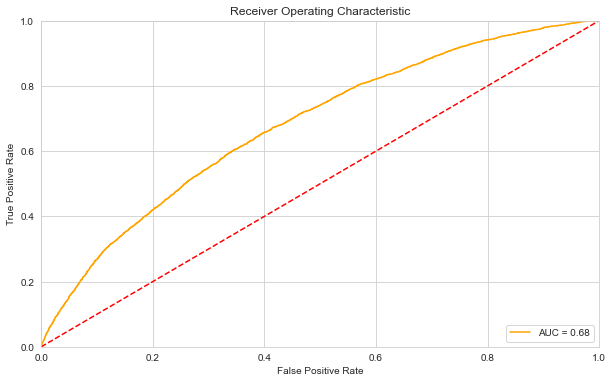

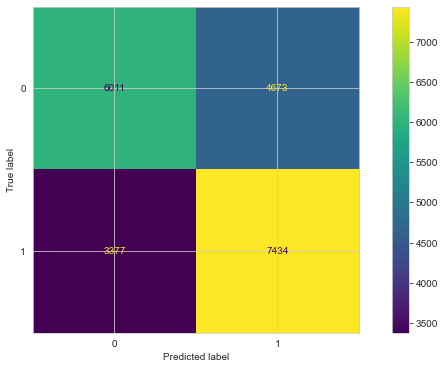

In [69]:
#-------------------------------- Model testing ---------------------------------#

# Predict for X_test data set using the fitted model
y_pred_final_model = final_model.predict(X_test)

#-------------------------------- Model evaluation ---------------------------------#
# Evaluate model accuracy using fitted y value and actual y_test
# Evaluation metrics to be used - eg. Precision, Recall, confusion matrix, ROC 

# Probabilities prediction on test set
probabilities = final_model.predict_proba(X_test)

# Display AUC and confusion matrix
print_metrics((y_test == 1), probabilities, 0.5)  

plot_auc((y_test == 1), probabilities)

get_count_confusion_metrics(final_model,X_test,y_test)

## 10.0 Use the hold out data provided to predict churners using the best identified model 

In [70]:
# Load and read file
holdout_df = pd.read_csv("Mini_project_3_Hold_Out_Data.csv") 
holdout_df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000006,NaN,57.49,483.0,37.0,0.25,23.0,0.0,532.0,51.0,8.3,1.0,61.3,1.7,0.3,55.3,46.3,6.3,83.7,157.0,9.3,0.0,5.7,56,1,1,MILMIL414,7,6,240,30.0,0.0,No,No,Yes,Yes,Yes,Unknown,Yes,Yes,No,No,No,Yes,0,0,No,Yes,0,5,No,1,150,No,5-Low,Other,Other,No
1,3000018,NaN,55.23,570.0,72.0,0.00,0.0,0.0,38.0,0.0,9.7,0.7,77.0,8.7,0.0,106.3,14.7,0.7,97.3,90.3,10.3,0.0,0.0,57,1,1,NNYSYR315,6,4,434,56.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,Yes,No,0,6,No,2,80,No,1-Highest,Other,Professional,No
2,3000034,NaN,97.34,1039.0,50.0,4.95,420.0,0.0,198.0,23.3,12.7,3.0,176.0,11.3,0.3,213.9,103.3,0.3,238.3,192.3,15.7,0.0,4.0,55,1,1,MILMIL414,3,3,700,38.0,24.0,No,No,No,No,No,Unknown,No,No,No,No,No,No,0,0,Yes,No,0,4,No,3,10,No,3-Good,Suburban,Crafts,Yes
3,3000070,NaN,35.59,153.0,30.0,0.00,16.0,0.0,30.0,7.3,2.0,0.7,17.3,0.0,0.0,33.1,8.0,4.7,48.3,7.0,2.7,0.0,0.3,59,3,2,SLCSLC801,6,5,48,46.0,0.0,Yes,No,Yes,Yes,Yes,Known,Yes,Yes,Yes,No,No,Yes,0,0,No,Yes,0,4,No,1,200,No,1-Highest,Other,Other,No
4,3000074,NaN,55.27,1213.0,50.0,0.74,0.0,1.3,169.0,1.0,2.7,6.0,43.7,4.3,0.0,490.1,50.7,8.3,189.3,105.0,8.7,0.0,4.3,52,1,1,OKCTUL918,4,4,408,58.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,Yes,0,3,No,0,10,No,1-Highest,Suburban,Other,No


In [71]:
# Create additional list of features 

def create_features(holdout_df):
    
    #3.1 Percent of current active subs over total subs
    holdout_df['perc_active_subs'] = holdout_df['ActiveSubs'] / holdout_df['UniqueSubs'] * 100
    
    #3.2 Percent of recurrent charge to monthly charge
    holdout_df['perc_recurrent_charge'] = holdout_df['TotalRecurringCharge'] / holdout_df['MonthlyRevenue'] * 100
    
    #3.3 Percent of overage minutes over total monthly minutes
    holdout_df['perc_overage_minutes'] = holdout_df['OverageMinutes'] / holdout_df['MonthlyMinutes'] * 100
  
    return holdout_df

create_features(holdout_df)

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,BlockedCalls,UnansweredCalls,CustomerCareCalls,ThreewayCalls,ReceivedCalls,OutboundCalls,InboundCalls,PeakCallsInOut,OffPeakCallsInOut,DroppedBlockedCalls,CallForwardingCalls,CallWaitingCalls,MonthsInService,UniqueSubs,ActiveSubs,ServiceArea,Handsets,HandsetModels,CurrentEquipmentDays,AgeHH1,AgeHH2,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,RVOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,RetentionOffersAccepted,NewCellphoneUser,NotNewCellphoneUser,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus,perc_active_subs,perc_recurrent_charge,perc_overage_minutes
0,3000006,NaN,57.49,483.0,37.0,0.25,23.0,0.0,532.0,51.0,8.3,1.0,61.3,1.7,0.3,55.3,46.3,6.3,83.7,157.0,9.3,0.0,5.7,56,1,1,MILMIL414,7,6,240,30.0,0.0,No,No,Yes,Yes,Yes,Unknown,Yes,Yes,No,No,No,Yes,0,0,No,Yes,0,5,No,1,150,No,5-Low,Other,Other,No,100.000000,64.359019,4.761905
1,3000018,NaN,55.23,570.0,72.0,0.00,0.0,0.0,38.0,0.0,9.7,0.7,77.0,8.7,0.0,106.3,14.7,0.7,97.3,90.3,10.3,0.0,0.0,57,1,1,NNYSYR315,6,4,434,56.0,0.0,No,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,Yes,No,0,6,No,2,80,No,1-Highest,Other,Professional,No,100.000000,130.363933,0.000000
2,3000034,NaN,97.34,1039.0,50.0,4.95,420.0,0.0,198.0,23.3,12.7,3.0,176.0,11.3,0.3,213.9,103.3,0.3,238.3,192.3,15.7,0.0,4.0,55,1,1,MILMIL414,3,3,700,38.0,24.0,No,No,No,No,No,Unknown,No,No,No,No,No,No,0,0,Yes,No,0,4,No,3,10,No,3-Good,Suburban,Crafts,Yes,100.000000,51.366345,40.423484
3,3000070,NaN,35.59,153.0,30.0,0.00,16.0,0.0,30.0,7.3,2.0,0.7,17.3,0.0,0.0,33.1,8.0,4.7,48.3,7.0,2.7,0.0,0.3,59,3,2,SLCSLC801,6,5,48,46.0,0.0,Yes,No,Yes,Yes,Yes,Known,Yes,Yes,Yes,No,No,Yes,0,0,No,Yes,0,4,No,1,200,No,1-Highest,Other,Other,No,66.666667,84.293341,10.457516
4,3000074,NaN,55.27,1213.0,50.0,0.74,0.0,1.3,169.0,1.0,2.7,6.0,43.7,4.3,0.0,490.1,50.7,8.3,189.3,105.0,8.7,0.0,4.3,52,1,1,OKCTUL918,4,4,408,58.0,0.0,No,No,Yes,No,No,Known,Yes,Yes,No,No,No,Yes,0,0,No,Yes,0,3,No,0,10,No,1-Highest,Suburban,Other,No,100.000000,90.464990,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3399938,NaN,85.15,815.0,88.0,0.00,1.0,0.4,0.0,0.0,12.0,0.0,15.3,0.0,1.3,141.0,9.0,3.3,72.0,38.7,12.0,0.0,0.0,27,3,2,LAXVNY818,3,3,230,64.0,64.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,No,No,0,0,No,0,40,No,1-Highest,Other,Other,Unknown,66.666667,103.347035,0.122699
19996,3399950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,1.7,0.0,0.0,0.0,25,1,1,LAXRIV909,1,1,773,34.0,26.0,No,No,Yes,No,No,Known,No,No,No,No,Yes,Yes,0,0,No,No,0,6,No,0,Unknown,No,1-Highest,Suburban,Other,Yes,100.000000,NaN,NaN
19997,3399966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,1.3,0.7,0.3,5.3,3.3,0.0,0.0,0.0,25,1,1,LAXCOR909,1,1,773,0.0,0.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,Yes,No,0,8,No,1,Unknown,No,1-Highest,Suburban,Other,No,100.000000,NaN,NaN
19998,3399970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,3.3,26.7,4.3,0.0,235.4,35.0,3.3,146.3,115.3,22.3,0.0,6.3,25,1,1,LAXLAG949,3,2,32,28.0,48.0,No,No,Yes,No,No,Unknown,No,No,No,No,No,Yes,0,0,No,No,0,3,No,0,150,No,3-Good,Other,Other,Unknown,100.000000,NaN,NaN


In [72]:
# Drop variables defined earlier
holdout_df = holdout_df.drop(drop_list,axis = "columns")
holdout_df.shape

(20000, 35)

In [73]:
holdout_df.isnull().sum() / holdout_df.shape[0] * 100

Churn                        100.000
MonthlyRevenue                 0.300
MonthlyMinutes                 0.300
DirectorAssistedCalls          0.300
RoamingCalls                   0.300
PercChangeMinutes              0.675
PercChangeRevenues             0.675
DroppedCalls                   0.000
CustomerCareCalls              0.000
OutboundCalls                  0.000
InboundCalls                   0.000
OffPeakCallsInOut              0.000
MonthsInService                0.000
UniqueSubs                     0.000
HandsetModels                  0.000
CurrentEquipmentDays           0.000
ChildrenInHH                   0.000
HandsetRefurbished             0.000
HandsetWebCapable              0.000
TruckOwner                     0.000
Homeownership                  0.000
BuysViaMailOrder               0.000
RespondsToMailOffers           0.000
OptOutMailings                 0.000
NonUSTravel                    0.000
OwnsComputer                   0.000
HasCreditCard                  0.000
R

In [74]:
# Impute null with mean
holdout_df.fillna(holdout_df.mean(), inplace = True)
holdout_df

,Churn,MonthlyRevenue,MonthlyMinutes,DirectorAssistedCalls,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,CustomerCareCalls,OutboundCalls,InboundCalls,OffPeakCallsInOut,MonthsInService,UniqueSubs,HandsetModels,CurrentEquipmentDays,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,NewCellphoneUser,ReferralsMadeBySubscriber,OwnsMotorcycle,MadeCallToRetentionTeam,CreditRating,Occupation,perc_overage_minutes
0,NaN,57.490000,483.000000,0.250000,0.000000,532.000000,51.000000,8.3,1.7,46.3,6.3,157.0,56,1,6,240,No,No,Yes,Yes,Unknown,Yes,Yes,No,No,No,Yes,0,No,0,No,No,5-Low,Other,4.761905
1,NaN,55.230000,570.000000,0.000000,0.000000,38.000000,0.000000,9.7,8.7,14.7,0.7,90.3,57,1,4,434,No,No,Yes,No,Known,No,No,No,No,Yes,Yes,0,Yes,0,No,No,1-Highest,Professional,0.000000
2,NaN,97.340000,1039.000000,4.950000,0.000000,198.000000,23.300000,12.7,11.3,103.3,0.3,192.3,55,1,3,700,No,No,No,No,Unknown,No,No,No,No,No,No,0,Yes,0,No,No,3-Good,Crafts,40.423484
3,NaN,35.590000,153.000000,0.000000,0.000000,30.000000,7.300000,2.0,0.0,8.0,4.7,7.0,59,3,5,48,Yes,No,Yes,Yes,Known,Yes,Yes,Yes,No,No,Yes,0,No,0,No,No,1-Highest,Other,10.457516
4,NaN,55.270000,1213.000000,0.740000,1.300000,169.000000,1.000000,2.7,4.3,50.7,8.3,105.0,52,1,4,408,No,No,Yes,No,Known,Yes,Yes,No,No,No,Yes,0,No,0,No,No,1-Highest,Other,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,NaN,85.150000,815.000000,0.000000,0.400000,0.000000,0.000000,12.0,0.0,9.0,3.3,38.7,27,3,3,230,No,No,Yes,No,Unknown,No,No,No,No,No,Yes,0,No,0,No,No,1-Highest,Other,0.122699
19996,NaN,58.899712,525.912136,0.893764,1.186765,-9.052806,-1.237246,0.0,0.0,0.0,0.0,1.7,25,1,1,773,No,No,Yes,No,Known,No,No,No,No,Yes,Yes,0,No,0,No,No,1-Highest,Other,6.258743
19997,NaN,58.899712,525.912136,0.893764,1.186765,-9.052806,-1.237246,0.0,0.0,0.7,0.3,3.3,25,1,1,773,No,No,Yes,No,Unknown,No,No,No,No,No,Yes,0,Yes,0,No,No,1-Highest,Other,6.258743
19998,NaN,58.899712,525.912136,0.893764,1.186765,-9.052806,-1.237246,19.0,4.3,35.0,3.3,115.3,25,1,2,32,No,No,Yes,No,Unknown,No,No,No,No,No,Yes,0,No,0,No,No,3-Good,Other,6.258743


In [75]:
# Define X,y
X = holdout_df.drop('Churn', axis = 1)
y = holdout_df.Churn

# Scaling for sel_num_fea
sc = StandardScaler()
X_scaled = sc.fit_transform(X[sel_num_fea])
X_scaled = pd.DataFrame(X_scaled, columns = sel_num_fea)

# Get dummy for cat_num_fea
X_dummy = pd.get_dummies(X)
X_dummy.update(X_scaled)

X = X_dummy

In [76]:
# Use final_model (tuned RandomForest Classifier model) to predict y in holdout data
y_pred_holdout_df = final_model.predict(X)

In [77]:
# Churn probability 
probabilities = final_model.predict_proba(X)

In [78]:
# Input predicted probability into Churn column
holdout_df['Churn'] = probabilities
holdout_df

,Churn,MonthlyRevenue,MonthlyMinutes,DirectorAssistedCalls,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,CustomerCareCalls,OutboundCalls,InboundCalls,OffPeakCallsInOut,MonthsInService,UniqueSubs,HandsetModels,CurrentEquipmentDays,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,NewCellphoneUser,ReferralsMadeBySubscriber,OwnsMotorcycle,MadeCallToRetentionTeam,CreditRating,Occupation,perc_overage_minutes
0,0.627203,57.490000,483.000000,0.250000,0.000000,532.000000,51.000000,8.3,1.7,46.3,6.3,157.0,56,1,6,240,No,No,Yes,Yes,Unknown,Yes,Yes,No,No,No,Yes,0,No,0,No,No,5-Low,Other,4.761905
1,0.575084,55.230000,570.000000,0.000000,0.000000,38.000000,0.000000,9.7,8.7,14.7,0.7,90.3,57,1,4,434,No,No,Yes,No,Known,No,No,No,No,Yes,Yes,0,Yes,0,No,No,1-Highest,Professional,0.000000
2,0.490020,97.340000,1039.000000,4.950000,0.000000,198.000000,23.300000,12.7,11.3,103.3,0.3,192.3,55,1,3,700,No,No,No,No,Unknown,No,No,No,No,No,No,0,Yes,0,No,No,3-Good,Crafts,40.423484
3,0.666295,35.590000,153.000000,0.000000,0.000000,30.000000,7.300000,2.0,0.0,8.0,4.7,7.0,59,3,5,48,Yes,No,Yes,Yes,Known,Yes,Yes,Yes,No,No,Yes,0,No,0,No,No,1-Highest,Other,10.457516
4,0.601481,55.270000,1213.000000,0.740000,1.300000,169.000000,1.000000,2.7,4.3,50.7,8.3,105.0,52,1,4,408,No,No,Yes,No,Known,Yes,Yes,No,No,No,Yes,0,No,0,No,No,1-Highest,Other,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.642031,85.150000,815.000000,0.000000,0.400000,0.000000,0.000000,12.0,0.0,9.0,3.3,38.7,27,3,3,230,No,No,Yes,No,Unknown,No,No,No,No,No,Yes,0,No,0,No,No,1-Highest,Other,0.122699
19996,0.427655,58.899712,525.912136,0.893764,1.186765,-9.052806,-1.237246,0.0,0.0,0.0,0.0,1.7,25,1,1,773,No,No,Yes,No,Known,No,No,No,No,Yes,Yes,0,No,0,No,No,1-Highest,Other,6.258743
19997,0.432691,58.899712,525.912136,0.893764,1.186765,-9.052806,-1.237246,0.0,0.0,0.7,0.3,3.3,25,1,1,773,No,No,Yes,No,Unknown,No,No,No,No,No,Yes,0,Yes,0,No,No,1-Highest,Other,6.258743
19998,0.666728,58.899712,525.912136,0.893764,1.186765,-9.052806,-1.237246,19.0,4.3,35.0,3.3,115.3,25,1,2,32,No,No,Yes,No,Unknown,No,No,No,No,No,Yes,0,No,0,No,No,3-Good,Other,6.258743


In [79]:
# Check churn prediction result based on threshold of 0.6
prediction_result = holdout_df[holdout_df['Churn'] > 0.6 ]
prediction_result['Churn'].sum() / prediction_result.shape[0] *100

67.9302793916456

<mark>__Results:__
    
Churn prediction for the holdout data is about 67% based on tuned RandomForest Classifier model.

## 11.0 Calculate lift chart and total monthly revenue saved by targeting top 10-20% of the customers using best predictive model

In [80]:
def calc_cumulative_gains(df: pd.DataFrame, actual_col: str, predicted_col:str, probability_col:str):

    df.sort_values(by=probability_col, ascending=False, inplace=True)

    subset = df

    rows = []
    for group in np.array_split(subset, 10):
        
        score= sum(group[actual_col].tolist())
        
        rows.append({'NumCases': len(group), 'ActualChurn': score})

    lift = pd.DataFrame(rows)

    #Cumulative Gains Calculation
    lift['CumActualChurn'] = lift['ActualChurn'].cumsum()
    lift['PercCorrect'] = lift.apply(
        lambda x: (100 / lift['ActualChurn'].sum()) * x['CumActualChurn'], axis=1)
    lift['CumNumCase'] = lift['NumCases'].cumsum()
    lift['AvgCase'] = lift['ActualChurn'].sum() / len(lift)
    lift['CumAvgCase'] = lift['AvgCase'].cumsum()
    lift['PercAvgCase'] = lift['CumAvgCase'].apply(
        lambda x: (100 / lift['ActualChurn'].sum()) * x)

    #Lift Chart
    lift['BaseLine'] = 1
    lift['PercWithModel'] = lift['PercCorrect'] / lift['PercAvgCase']

    return lift

def plot_lift_chart(lift: pd.DataFrame):
        plt.figure()
        plt.plot(lift['BaseLine'], 'r-', label='\'response rate\' with no model')
        plt.plot(lift['PercWithModel'], 'g-', label='\'response rate\' with using model')
        plt.legend()
        plt.show()

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

1.2208367566915226

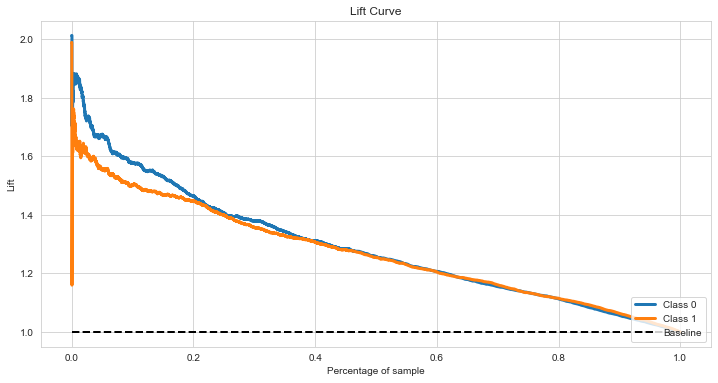

In [81]:
# Plot the lift chart from the best model

# Probabilities prediction on test set data
y_test_probs = final_model.predict_proba(X_test)

skplt.metrics.plot_lift_curve(y_test,y_test_probs,figsize=(12, 6))

lift_score(y_test,y_pred_final_model)

In [82]:
d = {'churn': y_test, 'pred_probs': y_test_probs[:,1],"predicted" : y_pred_final_model}
df = pd.DataFrame(data=d)
df

,churn,pred_probs,predicted
51316,1,0.576342,1
8350,0,0.328113,0
5453,1,0.612483,1
13504,0,0.576297,1
16801,1,0.497911,0
...,...,...,...
43699,0,0.640690,1
55054,1,0.587002,1
55269,1,0.502688,1
69917,1,0.533014,1


In [83]:
lift =calc_cumulative_gains(df,"churn","predicted","pred_probs")
lift

,NumCases,ActualChurn,CumActualChurn,PercCorrect,CumNumCase,AvgCase,CumAvgCase,PercAvgCase,BaseLine,PercWithModel
0,2150,1622,1622,15.003237,2150,1081.1,1081.1,10.0,1,1.500324
1,2150,1505,3127,28.924244,4300,1081.1,2162.2,20.0,1,1.446212
2,2150,1274,4401,40.708538,6450,1081.1,3243.3,30.0,1,1.356951
3,2150,1248,5649,52.252336,8600,1081.1,4324.4,40.0,1,1.306308
4,2150,1136,6785,62.760152,10750,1081.1,5405.5,50.0,1,1.255203
5,2149,1033,7818,72.315234,12899,1081.1,6486.6,60.0,1,1.205254
6,2149,965,8783,81.241328,15048,1081.1,7567.7,70.0,1,1.160590
7,2149,858,9641,89.177689,17197,1081.1,8648.8,80.0,1,1.114721
8,2149,706,10347,95.708075,19346,1081.1,9729.9,90.0,1,1.063423
9,2149,464,10811,100.000000,21495,1081.1,10811.0,100.0,1,1.000000


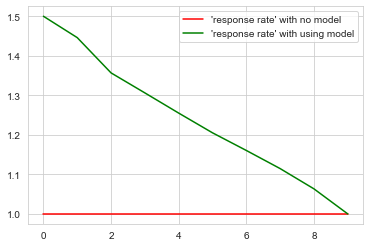

In [84]:
plot_lift_chart(lift)

In [85]:
top_churning_customers = lift.iloc[0:2,1].sum()
top_churning_customers

3127

In [86]:
rs_df2 = rs_df.copy()

In [87]:
churn = pd.DataFrame(y_test_probs)
rs_df2['Churn_Probability'] = churn[churn.columns[1]]
churn_df = rs_df2.sort_values('Churn_Probability',ascending=False).head(top_churning_customers)

In [88]:
churn_df

,MonthlyRevenue,MonthlyMinutes,DirectorAssistedCalls,RoamingCalls,PercChangeMinutes,PercChangeRevenues,DroppedCalls,CustomerCareCalls,OutboundCalls,InboundCalls,OffPeakCallsInOut,MonthsInService,UniqueSubs,HandsetModels,CurrentEquipmentDays,ChildrenInHH,HandsetRefurbished,HandsetWebCapable,TruckOwner,Homeownership,BuysViaMailOrder,RespondsToMailOffers,OptOutMailings,NonUSTravel,OwnsComputer,HasCreditCard,RetentionCalls,NewCellphoneUser,ReferralsMadeBySubscriber,OwnsMotorcycle,MadeCallToRetentionTeam,CreditRating,Occupation,perc_overage_minutes,Churn,Churn_Probability
9153,59.99,1210.0,0.00,0.0,-402.0,0.0,17.0,0.0,94.0,18.0,155.0,29,2,2.0,115.0,No,No,Yes,No,Known,Yes,Yes,No,Yes,Yes,Yes,0,Yes,0,No,No,1-Highest,Professional,0.000000,0,0.791778
3051,29.99,41.0,0.00,0.0,31.0,0.0,0.0,0.0,1.3,0.0,3.0,33,1,1.0,1018.0,No,No,Yes,No,Unknown,No,No,No,No,No,No,0,No,0,No,No,6-VeryLow,Other,0.000000,0,0.791778
750,35.34,184.0,0.25,0.1,48.0,0.6,1.3,0.0,11.0,1.7,27.7,49,1,2.0,624.0,No,Yes,Yes,No,Known,No,No,No,No,No,Yes,0,Yes,0,No,No,1-Highest,Other,0.000000,0,0.791138
6319,45.25,315.0,0.00,0.0,-18.0,-3.1,1.3,5.0,23.0,4.7,30.0,30,1,2.0,279.0,Yes,No,Yes,Yes,Known,No,No,No,No,No,Yes,0,No,0,No,No,6-VeryLow,Other,5.396825,0,0.789725
4223,25.65,50.0,0.00,0.0,-38.0,-8.7,1.7,0.0,0.0,0.0,6.0,32,1,2.0,393.0,No,No,Yes,No,Known,No,No,No,No,No,Yes,0,Yes,0,No,No,1-Highest,Other,50.000000,1,0.789702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7140,34.55,78.0,2.72,0.2,9.0,-2.6,3.7,0.0,0.0,0.3,6.3,29,1,1.0,869.0,No,No,Yes,No,Known,Yes,Yes,No,Yes,Yes,Yes,0,No,0,No,No,1-Highest,Professional,0.000000,0,0.614104
6705,79.40,416.0,1.49,0.0,261.0,88.2,5.0,0.3,26.3,1.0,53.0,28,1,1.0,843.0,No,No,Yes,No,Known,Yes,Yes,No,No,Yes,Yes,0,No,0,No,No,2-High,Other,25.961538,0,0.614101
20822,48.66,284.0,0.00,0.0,30.0,-0.4,3.7,0.0,9.3,23.0,51.7,16,3,1.0,472.0,No,Yes,No,Yes,Unknown,No,No,No,No,No,No,0,No,0,No,No,2-High,Other,0.000000,0,0.614079
782,62.22,718.0,0.25,0.0,-6.0,-9.1,1.3,0.0,17.3,2.3,43.0,44,1,6.0,59.0,No,No,Yes,No,Known,No,No,No,No,No,Yes,0,No,0,No,No,1-Highest,Clerical,3.481894,1,0.614064


In [89]:
churn_df.MonthlyRevenue.sum()

180798.2357187777

<mark>__Results:__
    
1. It's about 28% actual churn captured by targeting top 20% (top 2 deciles) of the customers sorted by their churn probability.
2. The total monthly revenue of actual churn customers identified in the top 20% of the customers is 178828.22.
   